In [1]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [2]:
"""
Created on September 8 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))

Zernike_Module.__version__: 0.33b
Zernike_Analysis_Module.__version__: 0.26b


In [6]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.18.5
0.17.2
1.5.0
1.0.5


# Test run update 

## scripts 

### first test run - test times

In [146]:
finalHgAr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020",allow_pickle=True)
finalNe_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020",allow_pickle=True)

In [147]:
list_of_HgAr_to_analyze=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index
list_of_Ne_to_analyze=finalNe_Feb2020_dataset[finalNe_Feb2020_dataset['close']=='1'].index

In [148]:
print(len(list_of_Ne_to_analyze))
print(len(list_of_HgAr_to_analyze))
print(list_of_HgAr_to_analyze)
print(list_of_Ne_to_analyze)

def remove(string): 
    return string.replace(" ", "")

40
50
Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')
Int64Index([ 2,  5,  6,  7, 11, 14, 15, 16, 20, 23, 24, 25, 29, 32, 33, 34, 38,
            41, 42, 43, 47, 50, 51, 52, 56, 59, 60, 61, 65, 68, 69, 70, 74, 77,
            78, 79, 83, 86, 87, 88],
           dtype='int64')


In [154]:
for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ne_1_'+str(single_spot)+'Sep20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=3 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 01:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, m05, 0, p05, p3, p35, p4
    file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 21556 21562 21568 21598 21604 21610 21640 21646 21652 -spot "+str(single_spot)+\
               " -nsteps 100 -eps 6 -dataset 4 -arc Ne -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output Sep13 -analysis_type defocus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Sep20ScriptToSubmitScriptsTiger_Ne_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_Ne_1_'+str(single_spot)+'Sep20.sh \n')

file.close()

In [155]:

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_HgAr_1_'+str(single_spot)+'Sep20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=3 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 01:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, p3, p35, p4
    file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 21352 21358 21364 21394 21400 21406 21436 21442 21448 -spot "+str(single_spot)+\
               " -nsteps 100 -eps 6 -dataset 4 -arc HgAr -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output Sep13 -analysis_type defocus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Sep20ScriptToSubmitScriptsTiger_HgAr_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_HgAr_1_'+str(single_spot)+'Sep20.sh \n')

file.close()

## which images are avaliable - Jul20 

In [91]:
finalHgAr

NameError: name 'finalHgAr' is not defined

## single image 

In [11]:
#date='Jul2020'
date='Sep1320'
obs=21400
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
obs_int=int(obs)
single_number='37'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

labelInput: 0
self.single_number: 37
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [21352, 21358, 21364, 21394, 21400, 21406, 21436, 21442, 21448]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020'>
analyzing label: 21400
double_sources_positions_ratios for this spot is: [0 0]


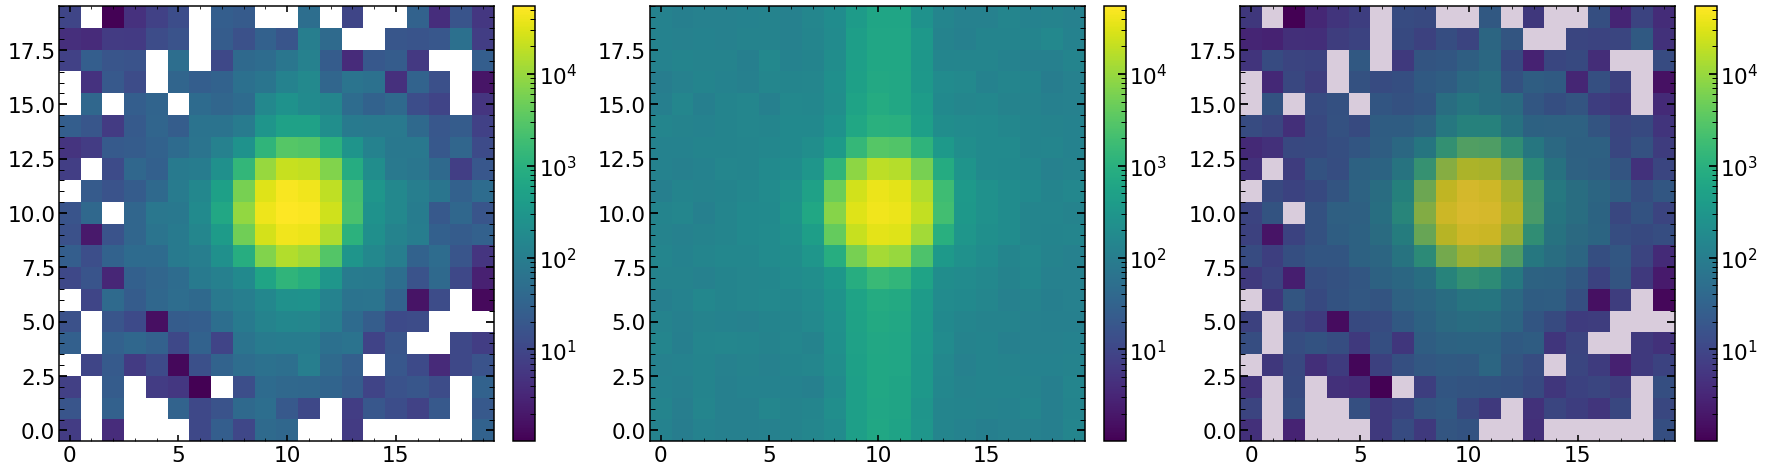

In [12]:
single_analysis=Zernike_Analysis(date=date,obs='0',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [13]:
#single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
#                                 list_of_defocuses=['m4','m35','m3','m05','0','p05','p3','p35','p4'])


double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

(100, 120, 129)
(100, 120, 129)
minimal likelihood is: 6777.242018620828
minimal chi2 reduced is (makes no sense for multi_var): 26.536606211268204


(0.060864308507655895, 0.2608643085076559)

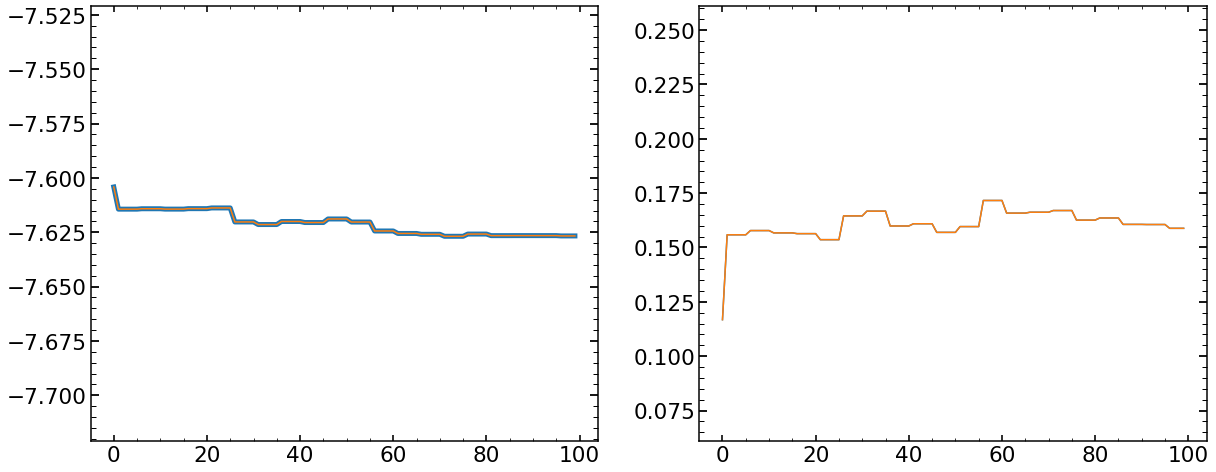

In [14]:
# wavefront paramter
plt.figure(figsize=(20,8))
i=0*2
plt.subplot(121)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,78][:,i],lw=5)
plt.plot(chain0_swarm_1[:,28][:,i])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)


plt.subplot(122)
#  paramter 2 (z5)

mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,2])
plt.ylim(mean_one_what-0.1,mean_one_what+0.1)


Text(0.5, 0, 'nstep')

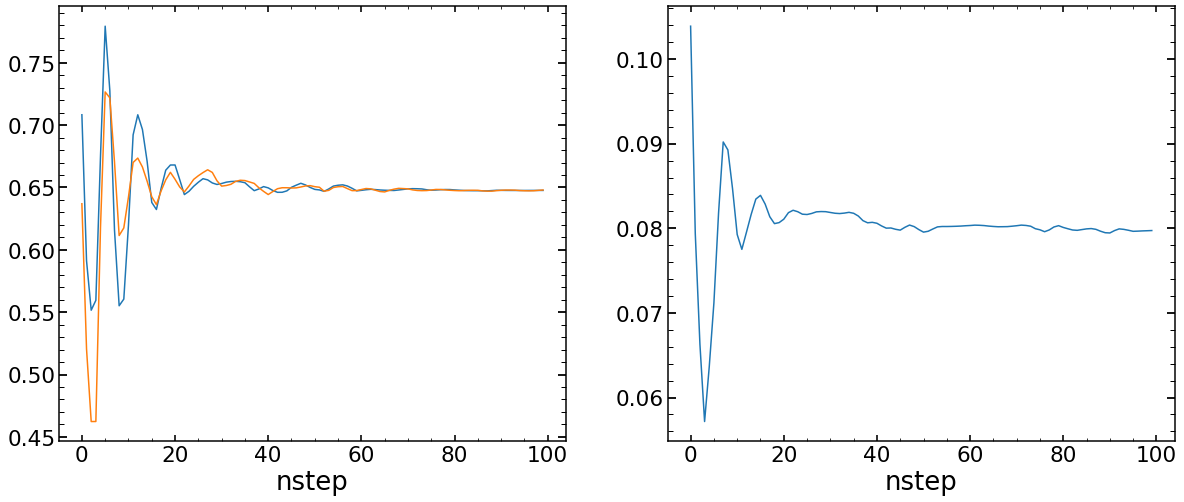

In [15]:
# pupil paramter
plt.figure(figsize=(20,8))
i=19*2
plt.subplot(121)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,78][:,i])
plt.plot(chain0_swarm_1[:,28][:,i])
plt.xlabel('nstep')

plt.subplot(122)
plt.plot(chain0_swarm_1[:,:,i+1][:,2])
plt.xlabel('nstep')

Text(0, 0.5, 'std. devation of a single parameter')

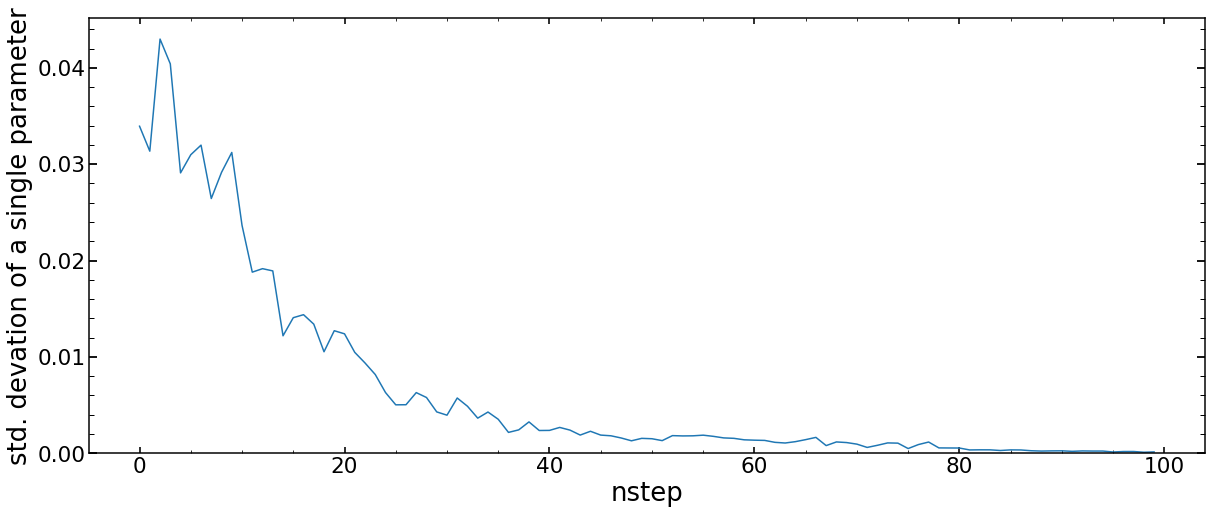

In [16]:
list_of_std=[]
i=19*2+0
for j in range(len(chain0_swarm_1)):
    list_of_std.append(np.std(chain0_swarm_1[:,:,i][j]))

plt.figure(figsize=(20,8))
plt.plot(list_of_std)
plt.ylim(0)
plt.xlabel('nstep')
plt.ylabel('std. devation of a single parameter')

In [501]:
len(chain0_swarm_1)

100

## Image creation and image analysis


In [502]:
minchain_parametrization

array([   -7.62654872,     0.16056239,     0.09493409,     0.37560671,
           0.04743266,    -0.46094586,    -0.00303878,     0.57212998,
           0.00285846,     0.0612378 ,     0.00831685,    -0.03968159,
           0.03293613,    -0.31681056,     0.02257466,    -0.37194885,
          -0.00055462,     0.00525614,    -0.00365375,    -0.09386249,
           0.01574472,     0.01384797,     0.00680921,     0.02363862,
          -0.00172736,    -0.01769629,    -0.00659394,    -0.01362594,
          -0.00675819,     0.00182017,    -0.00394622,    -0.00754178,
           0.00212247,    -0.02210636,    -0.00215161,     0.01428548,
           0.00161138,     0.02695326,     0.64763255,     0.07972058,
          -0.07504414,    -0.06657529,     0.05511363,     0.02942104,
           0.00001627,     0.00001627,     0.97483602,     0.94833824,
           0.02253383,    -0.03586997,     0.9313411 ,     0.06865397,
           0.42454705,     1.0291687 ,     0.27632026, 87381.13193628,
      

In [17]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=56,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

res_multi=model_multi(list_of_minchain,return_Images=True)


mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: -3.1847658
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 158.74033
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.33b
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   30.66675729    -0.00412966    -0.65067649     0.58428509
     0.04980397    -0.072949      -0.44855507    -0.46224749
     0.00747463    -0.07924748    -0.04913092    -0.00359824
    -0.01078687     0.01274981     0.02885293     0.0082431
    -0.03059624     0.02289192     0.02050776     0.64763255
     0.07972058    -0.07504414    -0.06657529     0.05511363
     0.02942104     

Time to apodize the pupil: 0.11772513389587402
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.25710105895996094
Time for pupil and illumination calculation is 0.2623419761657715

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 26.853482923994964, 0.043337387563451235, -0.626960161589663, 0.5827656986301027, 0.05123320156984184, -0.06879057132686081, -0.43208700824750157, -0.4509601577943821, 0.007197318853262044, -0.08107435480819902, -0.041258559917336464, -0.00019363449297789617, -0.011650550970769369, 0.009452837949785804, 0.02547383379900092, 0.006269988892383961, -0.029535001658387253, 0.02181611507201541, 0.02131344378497665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.043337387563451235, -0.626960161589663, 0.582

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9748360240425038, 0.9483382390642031, 1.6270012420680348e-05, 1.6267129556216536e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.14065217971801758
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.29515910148620605
Time for pupil and illumination calculation is 0.30237698554992676

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 23.040208562125574, 0.09080443352661816, -0.6032438322023701, 0.5812463103614656, 0.05266243055530449, -0.06463214544075901, -0.41561894457751236, -0.4396728281171849, 0.006920007744332342, -0.08290123095518606, -0.0333861983916017, 0.0032109728316297263, -0.0125142284765773, 0.00615586956458

Time to apodize the pupil: 0.14296221733093262
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.29308199882507324
Time for pupil and illumination calculation is 0.29922914505004883

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 3.9738367527786225, 0.3281396633424527, -0.48466218526590576, 0.57364936901828, 0.05980857548261777, -0.04384001601024996, -0.3332786262275663, -0.3832361797311987, 0.005533452199683832, -0.09203561169012126, 0.0059756092370721, 0.02023400945466783, -0.01683261600561696, -0.01032897236144211, 0.005199265896441576, -0.005568668904405093, -0.023167591803637092, 0.015361287238713934, 0.026147570659961705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.3281396633424527, -0.48466218526590576, 0.573649369


Entering lnlike_Neven
allparameters [    0.16056239     0.37560671    -0.46094586     0.57212998
     0.0612378     -0.03968159    -0.31681056    -0.37194885
     0.00525614    -0.09386249     0.01384797     0.02363862
    -0.01769629    -0.01362594     0.00182017    -0.00754178
    -0.02210636     0.01428548     0.02695326     0.64763255
     0.07972058    -0.07504414    -0.06657529     0.05511363
     0.02942104     0.00001627     0.00001627     0.97483602
     0.94833824     0.02253383    -0.03586997     0.9313411
     0.06865397     0.42454705     1.0291687      0.27632026
 87381.13193628     2.38689243     0.00235943     0.35323491
     1.82265232     1.00000022    -0.00498864     0.00038788
    -0.00047359    -0.00845299    -0.00600506     0.00428279
     0.00509663     0.00255388    -0.00129079    -0.0013989
     0.00380027     0.00633867     0.00059437    -0.00600926
     0.0033456     -0.00073576    -0.00308738    -0.00311842
     0.00850074     0.00669177    -0.00259584    -

Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9942130364509757
Finished with lnlike_Neven
chi_2_almost/d.o.f is 5.3900795; chi_2_almost_max_dof is 1797.2603 log(improvment) is -2.5230157
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4664489408
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4664489408 is: 1.31819486618042 seconds
 
################################
analyzing image 6 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: 8.3153105
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 127.86445
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supp

chi2 within shgo optimization routine (chi_2_almost_multi_values): 7091.102
chi2 within shgo optimization routine (chi_2_almost_multi_values): 1454.3911
chi2 within shgo optimization routine (chi_2_almost_multi_values): 964.93555
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.231305
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.2313023
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.231306
chi2 within shgo optimization routine (chi_2_almost_multi_values): 11968.685
chi2 within shgo optimization routine (chi_2_almost_multi_values): 46.232216
chi2 within shgo optimization routine (chi_2_almost_multi_values): 11.215961
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.8617997
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.058857
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.0470386
chi2 within shgo optimization routine (chi_2_almost_multi_values): 5.1111555
chi

Time for wavefront and wavefront/pupil combining is 0.00035190582275390625
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.47829604148864746
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2476
optPsf_cut.shape(2477, 2477)
oversampling:9.0
optPsf_cut.shape[0]2477
size_of_optPsf_cut_downsampled: 630.0
optPsf_cut_downsampled.shape: (631, 631)
size_of_optPsf_cut_in_Microns: 1051.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[87381.1319362766, 2.386892433013564, 0.002359429817613121, 0.3532349145515378, 1.8226523203538425]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(631, 631)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ratio is:[0 0]
Time for

Time to apodize the pupil: 0.13073205947875977
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2753159999847412
Time for pupil and illumination calculation is 0.28037309646606445

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -26.532358142176502, 0.7078760310477881, -0.2949315501675629, 0.5614942628691831, 0.07124240736631901, -0.010572608921435488, -0.20153411686765269, -0.29293754231362085, 0.0033149633282462173, -0.10665062086601756, 0.06895450144295018, 0.047470868051528795, -0.02374203605208041, -0.03670471944307933, -0.02183349130697088, -0.021353545966790496, -0.014677711997303548, 0.006754850127645299, 0.03259307315994178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.7078760310477881, -0.2949315501675629, 0.5614

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9748360240425038, 0.9483382390642031, 1.6270012420680348e-05, 1.6267129556216536e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.13037109375
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2852339744567871
Time for pupil and illumination calculation is 0.2903468608856201

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -30.34563250404589, 0.7553430770109549, -0.27121522078027005, 0.5599748746005461, 0.07267163635178166, -0.006414183035333677, -0.18506605319766348, -0.28165021263642365, 0.0030376522193165155, -0.10847749701300462, 0.07682686296868495, 0.05087547537613641, -0.024605713557888344, -0.04000168782828398,

In [21]:
list_of_single_allparameters

[array([   30.66675729,    -0.00412966,    -0.65067649,     0.58428509,
            0.04980397,    -0.072949  ,    -0.44855507,    -0.46224749,
            0.00747463,    -0.07924748,    -0.04913092,    -0.00359824,
           -0.01078687,     0.01274981,     0.02885293,     0.0082431 ,
           -0.03059624,     0.02289192,     0.02050776,     0.64763255,
            0.07972058,    -0.07504414,    -0.06657529,     0.05511363,
            0.02942104,     0.00001627,     0.00001627,     0.97483602,
            0.94833824,     0.02253383,    -0.03586997,     0.9313411 ,
            0.06865397,     0.42454705,     1.0291687 ,     0.27632026,
        87381.13193628,     2.38689243,     0.00235943,     0.35323491,
            1.82265232,     1.        ,    -0.00397035,    -0.00080248,
           -0.00182131,    -0.01142717,    -0.00744409,     0.0103055 ,
            0.00142023,     0.00751632,     0.00443184,    -0.00551814,
           -0.00063624,     0.00890376,    -0.00049597,    -0.00

In [504]:
# likelihood, max likelihood, chi2, max chi2
list_of_single_chi_results

[[189015.28, 41439068.0, 52.504246, 11510.853],
 [114552.92, 33742410.0, 45.8946, 13518.593],
 [70269.42, 27542700.0, 43.91839, 17214.188],
 [6343.583, 1796423.5, 15.858957, 4491.0586],
 [2156.0317, 718904.1, 5.3900795, 1797.2603],
 [2055.2087, 1141072.0, 5.138022, 2852.68],
 [92502.41, 27330900.0, 37.00096, 10932.36],
 [154960.75, 37398264.0, 43.236816, 10434.783],
 [253714.75, 48936816.0, 70.47632, 13593.56]]

(100, 120, 129)
minimal likelihood is: 6777.242018620828
minimal chi2 reduced is (makes no sense for multi_var): 26.536606211268204
(100, 120, 129)


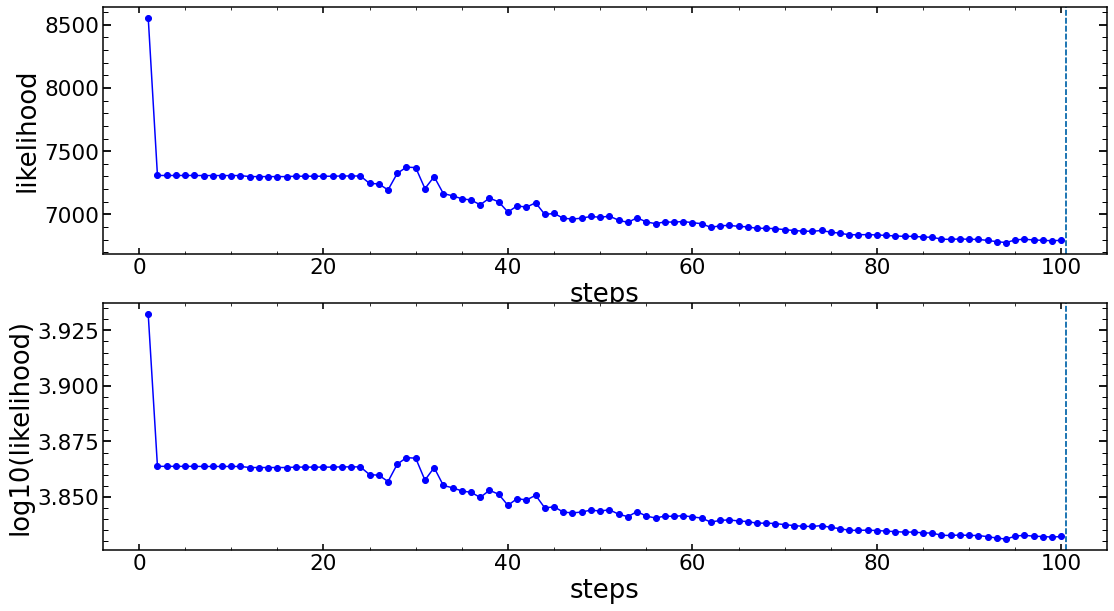

In [505]:
single_analysis.create_fitting_evolution_plot()

In [506]:
minchain=list_of_minchain[1]

print(minchain.shape)

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)

dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:30]]),columns=columns22[19:30])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][30:41]]),columns=columns22[30:41])
print(dfglobal2)

(76,)
          z4        z5       z6        z7        z8        z9       z10  \
0  26.853483  0.043337 -0.62696  0.582766  0.051233 -0.068791 -0.432087   

       z11  
0 -0.45096  
        z12       z13       z14       z15       z16       z17       z18  \
0  0.007197 -0.081074 -0.041259 -0.000194 -0.011651  0.009453  0.025474   

       z19       z20       z21       z22  
0  0.00627 -0.029535  0.021816  0.021313  

    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.647633   0.079721 -0.075044 -0.066575  0.055114     0.029421   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum   x_fiber  
0           0.000016             0.000016  0.974836  0.948338  0.022534  
   y_fiber  effective_radius_illumination  frd_sigma  frd_lorentz_factor  \
0 -0.03587                       0.931341   0.068654            0.424547   

   det_vert  slitHolder_frac_dx  grating_lines  scattering_slope  \
0  1.029169             0.27632   87381.131936          2.386892   

  

(-2.8, -1.5)

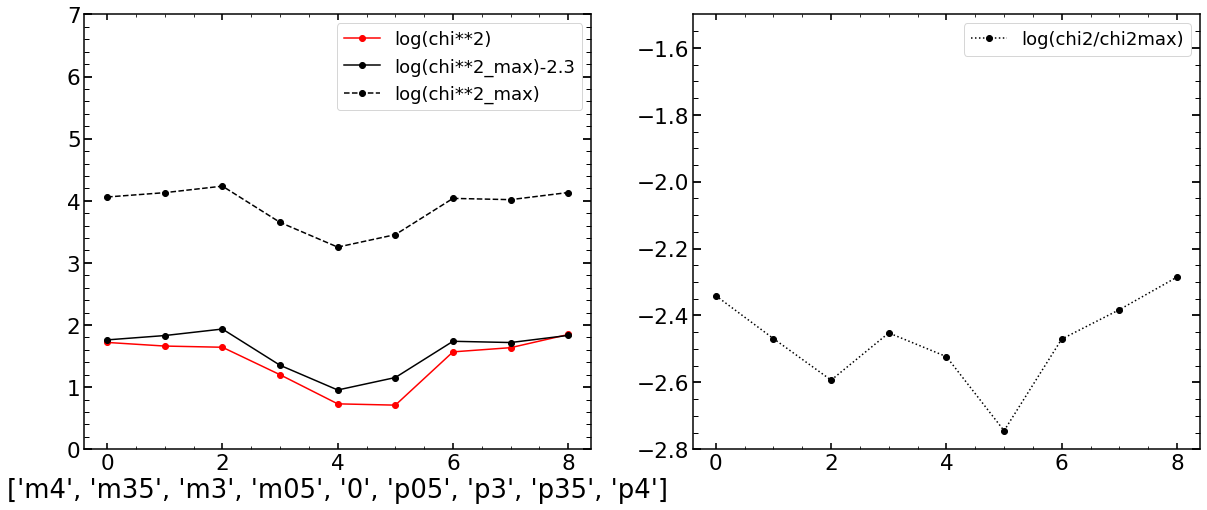

In [507]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi**2)',marker='o')
plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi**2_max)',marker='o',ls='--')
plt.ylim(0,7)
plt.xlabel(list_of_defocuses_input_long)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi2/chi2max)',marker='o',ls=':')
plt.legend()
plt.ylim(-2.8,-1.5)

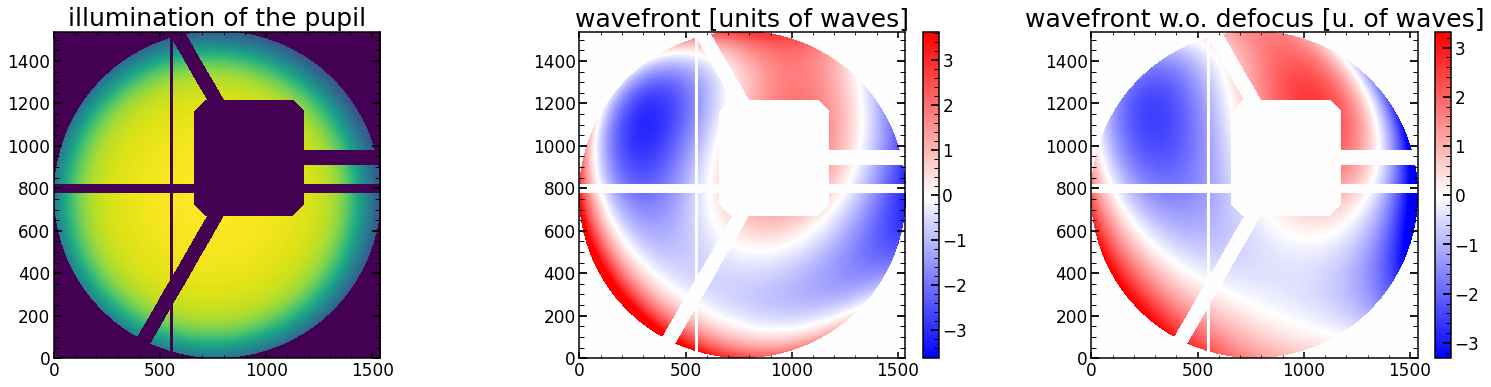

In [512]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 5.3900795
Abs of residual divided by total flux is: 0.04028874
Abs of residual divided by largest value of a flux in the image is: 0.03184321


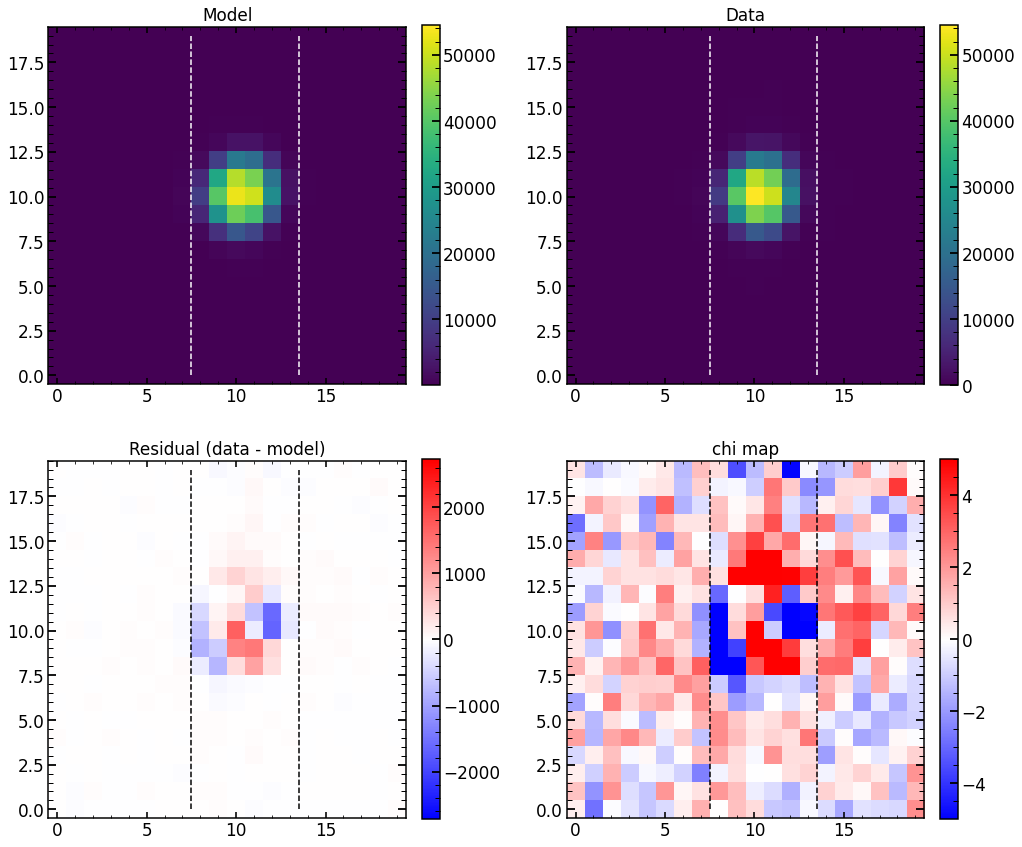

In [513]:
index_of_single_image=4

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

chi**2 max reduced is: 1791.8701
chi**2 reduced is: 5.3900795
Abs of residual divided by total flux is: 0.04028874
Abs of residual divided by largest value of a flux in the image is: 0.03184321


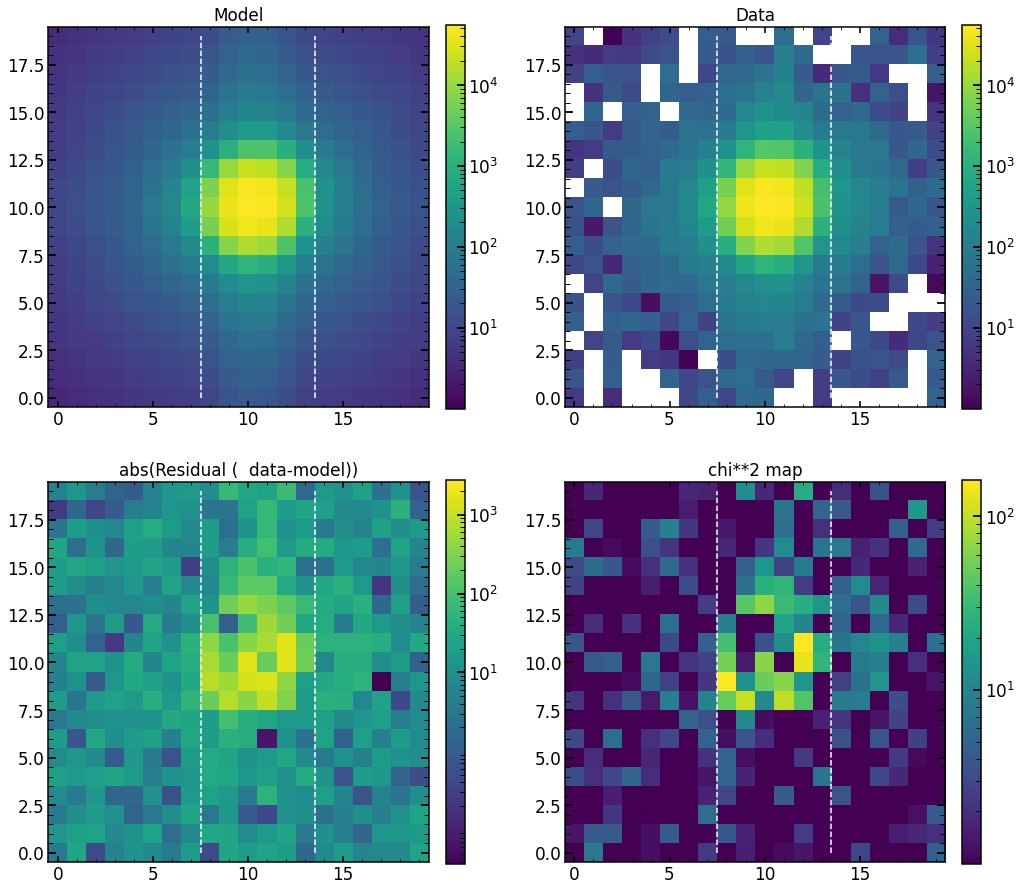

In [514]:
single_analysis.create_basic_comparison_plot_log(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

5.3900795
chi**2 reduced is: 5.3900795
Abs of residual divided by total flux is: 0.04028874
Abs of residual divided by largest value of a flux in the image is: 0.03184321


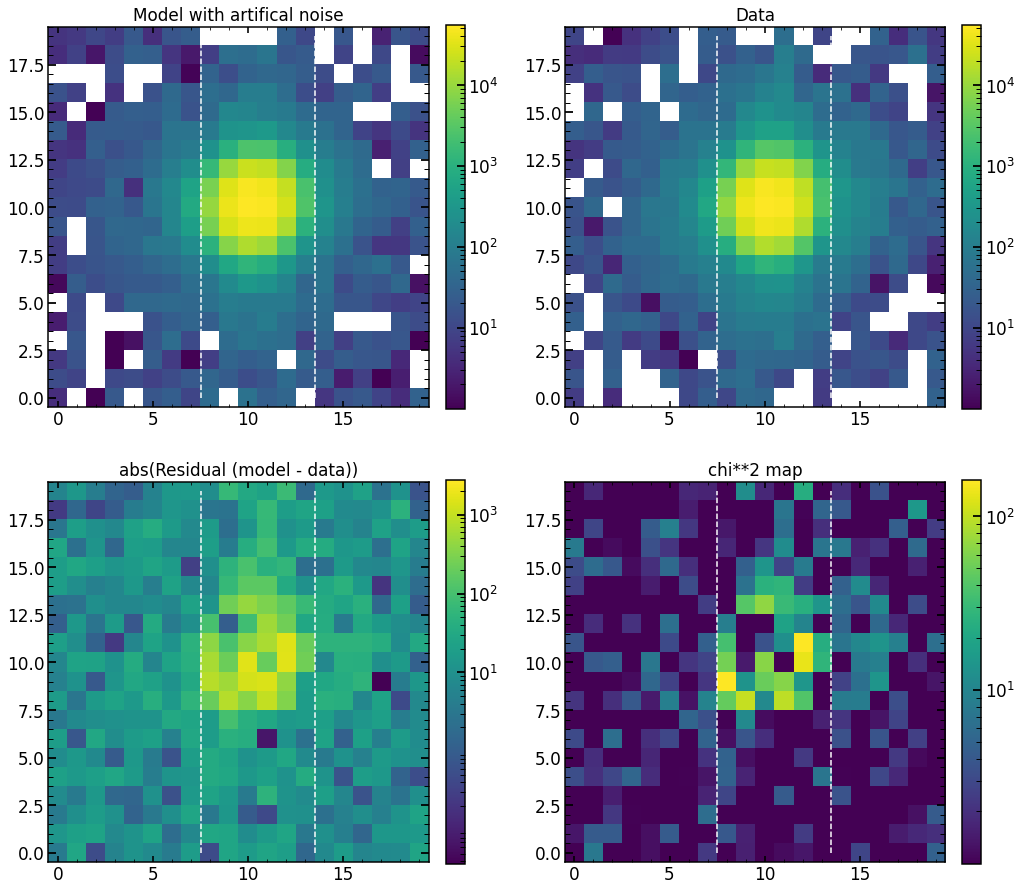

In [515]:
single_analysis.create_basic_comparison_plot_log_artifical(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

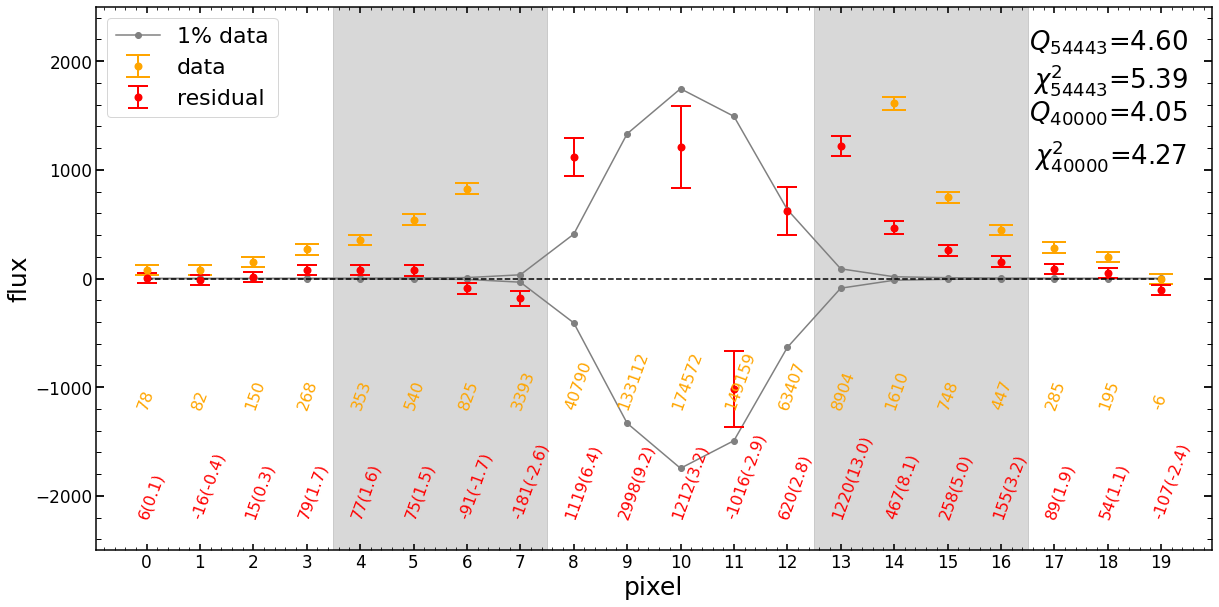

In [516]:
index_of_single_image=4
plot_1D_residual(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

In [11]:
import random

In [58]:
per_of_random=[]
for j in range(1000000):
    list_of_random=[]
    for i in range(5):
        
        list_of_random.append(np.ceil(random.uniform(-1,1) ))

    per_of_random.append(np.sum(list_of_random))
    
array_per_of_random=np.array(per_of_random)

In [59]:
len(array_per_of_random[array_per_of_random>=3])

500440

In [55]:
list_of_random

[1.0, -0.0, -0.0, -0.0, -0.0]

In [28]:
np.ceil(+0.5)

1.0

In [535]:
res_iapetus=list_of_single_model_image[index_of_single_image]
sci_image=list_of_sci_images[index_of_single_image]
var_image=list_of_var_images[index_of_single_image]

size=20
if size==20:
    x_center=find_centroid_of_flux(res_iapetus)[0]
else:
    x_center=(size/2)

left_limit=np.round(x_center-3.5)+0.5
right_limit=np.round(x_center+3.5)-0.5  

In [537]:
model_image=res_iapetus

init_lamda,std_init_lamda,init_removal_lamda,std_init_removal_lamda=residual_1D(sci_image,var_image,model_image)


position_of_max_flux=np.where(init_lamda==np.max(init_lamda))[0][0]
difference_from_max=range(20)-position_of_max_flux
pixels_to_test=np.array(range(20))[(np.abs(difference_from_max)>2)&(np.abs(difference_from_max)<=6)]
  

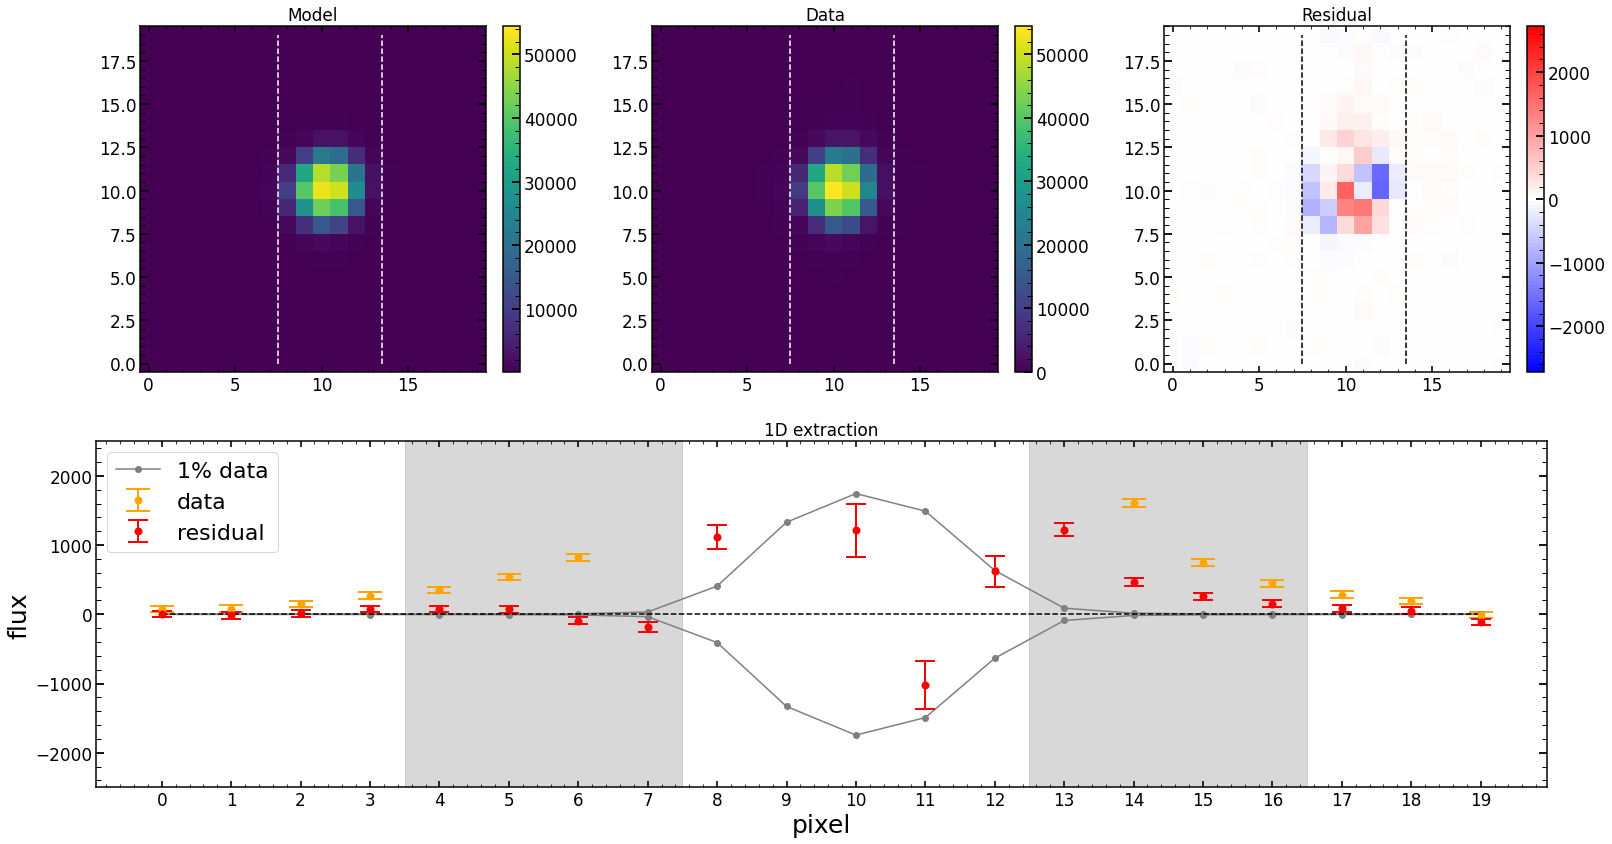

In [550]:
plt.figure(figsize=(26,14))    
plt.subplot(231)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*(left_limit),np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*(right_limit),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.grid(False)
plt.subplot(232)
plt.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*(left_limit),np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*(right_limit),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data')
plt.grid(False)
plt.subplot(233)
plt.title('Residual')
plt.imshow(sci_image-res_iapetus,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/20,vmax=np.max(np.abs(sci_image))/20)
plt.plot(np.ones(len(sci_image))*(left_limit),np.array(range(len(sci_image))),'--',color='black')
plt.plot(np.ones(len(sci_image))*(right_limit),np.array(range(len(sci_image))),'--',color='black')

plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(2,1,2)
plt.title('1D extraction')
plt.errorbar(np.array(range(len(init_lamda))),init_lamda,yerr=std_init_lamda,fmt='o',elinewidth=2,capsize=12,markeredgewidth=2,label='data',color='orange')
plt.plot(np.array(range(len(init_lamda))),init_lamda*0.01,color='gray',label='1% data',marker='o')
plt.plot(np.array(range(len(init_lamda))),-init_lamda*0.01,color='gray',marker='o')    
plt.errorbar(np.array(range(len(init_removal_lamda))),init_removal_lamda,yerr=std_init_removal_lamda,color='red',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='residual')

plt.legend(loc=2, fontsize=22)
plt.plot(np.zeros(20),'--',color='black')
plt.ylim(-2500,2500)
plt.ylabel('flux',size=25)
plt.xlabel('pixel',size=25)
plt.xticks(range(20))

plt.axvspan(pixels_to_test[0]-0.5, pixels_to_test[3]+0.5, alpha=0.3, color='grey')
plt.axvspan(pixels_to_test[4]-0.5, pixels_to_test[7]+0.5, alpha=0.3, color='grey')

# Hexapod experiment  - PIPE2D 584 - September data

In [25]:
Ar_positions_x_1=[474,733,1714,2614,3005]
Ar_positions_y_1=[3420,3406,3387,3388,3396]
Ar_positions_x_2=[477,731,1714,2614,3005]
Ar_positions_y_2=[1679,1668,1652,1654,1660]
Ar_positions_x_3=[477,731,1714,2614,3005]
Ar_positions_y_3=[2589,2576,2559,2561,2567]


In [326]:

list_of_centroids_array=[]
list_of_x_y_z=[]
for i in range(24507,24879+1):
    try:
        if i >=24621:
            hdul=fits.open('/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-09-05/sps/PFSA0'+str(i)+'12.fits')
        else:
            hdul=fits.open('/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-09-04/sps/PFSA0'+str(i)+'12.fits')


        x_y_z=[np.round(hdul[0].header['W_ENFCAX'],4),\
               np.round(hdul[0].header['W_ENFCAY'],4),\
               np.round(hdul[0].header['W_ENFCAZ'],4)]

        scidata=hdul[1].data
        print(i)
        print(x_y_z)

        size=10
        list_of_centroids_same_image=[]
        for Ar_positions_index in [0,1,2]:
            Ar_positions_y=[Ar_positions_y_1,Ar_positions_y_2,Ar_positions_y_3][Ar_positions_index]
            Ar_positions_x=[Ar_positions_x_1,Ar_positions_x_2,Ar_positions_x_3][Ar_positions_index]
            scidata_0=scidata[Ar_positions_y[0]-size:Ar_positions_y[0]+size,Ar_positions_x[0]-size:Ar_positions_x[0]+size]
            scidata_1=np.flip(scidata[Ar_positions_y[1]-size:Ar_positions_y[1]+size,Ar_positions_x[1]-size:Ar_positions_x[1]+size],axis=1)
            scidata_2=np.flip(scidata[Ar_positions_y[2]-size:Ar_positions_y[2]+size,Ar_positions_x[2]-size:Ar_positions_x[2]+size],axis=1)
            scidata_3=scidata[Ar_positions_y[3]-size:Ar_positions_y[3]+size,Ar_positions_x[3]-size:Ar_positions_x[3]+size]
            scidata_4=np.flip(scidata[Ar_positions_y[4]-size:Ar_positions_y[4]+size,Ar_positions_x[4]-size:Ar_positions_x[4]+size],axis=1)

            scidata_0=scidata_0-np.median(scidata_0)
            scidata_1=scidata_1-np.median(scidata_1)
            scidata_2=scidata_2-np.median(scidata_2)
            scidata_3=scidata_3-np.median(scidata_3)
            scidata_4=scidata_4-np.median(scidata_4)

            centroids_array=np.array([find_centroid_of_flux(scidata_0),find_centroid_of_flux(scidata_1),find_centroid_of_flux(scidata_2),find_centroid_of_flux(scidata_3),find_centroid_of_flux(scidata_4)])
            list_of_centroids_same_image.append(centroids_array)
        print(np.concatenate(list_of_centroids_same_image))
        list_of_centroids_array.append(np.concatenate(list_of_centroids_same_image))
        list_of_x_y_z.append(x_y_z)
    except:
        pass



24507
[-0.0, -0.0, -0.0]
[[ 9.73308979  9.81038242]
 [ 9.23549635  9.11026065]
 [10.07073178  9.27633044]
 [ 9.85425104 10.11957968]
 [ 9.36951126  9.19560174]
 [10.21979154  9.95539827]
 [ 9.34644552  9.28276286]
 [ 9.62937316  9.99994749]
 [ 9.2978999   9.50836492]
 [ 8.07647528  9.50080724]
 [10.04129662 16.26329676]
 [ 9.31701889 16.22225583]
 [ 9.96255956 16.24372059]
 [ 9.29516439 16.11452791]
 [ 8.17796226 16.36328605]]
24508
[-0.0, -0.0, -0.0]
[[ 9.7342387   9.80575454]
 [ 9.24095392  9.10325753]
 [10.07654931  9.26966577]
 [ 9.85262027 10.1175148 ]
 [ 9.37160196  9.19340097]
 [10.22488924  9.95164272]
 [ 9.34520683  9.2780028 ]
 [ 9.63214496  9.99832671]
 [ 9.29616755  9.50281086]
 [ 8.07530644  9.49660512]
 [10.04005058 16.24301576]
 [ 9.32592552 16.20586444]
 [ 9.9646364  16.23782581]
 [ 9.29535819 16.1150498 ]
 [ 8.17877039 16.34638351]]
24509
[0.0, -0.0, -0.0]
[[ 9.72950968  9.81518107]
 [ 9.23926889  9.11541357]
 [10.08793542  9.27576409]
 [ 9.79872108 10.12421125]
 [ 9.3

24528
[0.0, 0.05, 0.01]
[[10.01666714 11.3357157 ]
 [ 9.52425446 10.63506022]
 [10.38193351 10.80935577]
 [10.06779904 11.66141542]
 [ 9.66498562 10.74476205]
 [10.52051659 11.43783764]
 [ 9.63940935 10.76683545]
 [ 9.9213105  11.49222372]
 [ 9.58405425 11.00597506]
 [ 8.36769646 11.00162986]
 [10.32387389 14.88785978]
 [ 9.60754943 14.95259912]
 [10.24888101 14.40767914]
 [ 9.5801454  15.18421472]
 [ 8.45212327 14.23799295]]
24529
[0.0, 0.05, 0.0]
[[ 9.72532949 11.34960618]
 [ 9.23849893 10.64292873]
 [10.09265782 10.80813598]
 [ 9.78341596 11.65272979]
 [ 9.37336468 10.72607368]
 [10.22561016 11.44651701]
 [ 9.35243049 10.77356093]
 [ 9.6358381  11.48462376]
 [ 9.29620198 10.99302829]
 [ 8.0776406  10.99744545]
 [10.03840454 14.87318583]
 [ 9.31447315 14.9087978 ]
 [ 9.96279227 14.44730203]
 [ 9.2940666  15.23467066]
 [ 8.16943636 14.2311376 ]]
24530
[0.0, 0.05, 0.0]
[[ 9.72826566 11.3491101 ]
 [ 9.23826957 10.65028229]
 [10.09002497 10.81004296]
 [ 9.77731375 11.65511468]
 [ 9.37380

24548
[-0.0, 0.04, 0.05]
[[11.1825665  10.98231235]
 [10.68429946 10.29807855]
 [11.53783804 10.50914638]
 [11.22517546 11.37852931]
 [10.82414436 10.46901744]
 [11.67498512 11.10425124]
 [10.80103357 10.43951054]
 [11.07329746 11.20194477]
 [10.74113103 10.72610248]
 [ 9.53223757 10.72985554]
 [11.48851308 15.57621833]
 [10.76721297 15.59369834]
 [11.39299278 15.07115059]
 [10.74469385 15.70279197]
 [ 9.62121946 14.85654531]]
24549
[-0.0, 0.04, 0.05]
[[11.17920595 10.98110776]
 [10.6870161  10.29797194]
 [11.53905134 10.51465668]
 [11.21876087 11.37935946]
 [10.82545893 10.47311575]
 [11.66950939 11.10220245]
 [10.79200313 10.44671478]
 [11.07563922 11.20792239]
 [10.61905177 10.54006412]
 [ 9.52872962 10.73854314]
 [11.48423234 15.59854494]
 [10.77269853 15.55338393]
 [11.401525   15.06453877]
 [10.74268407 15.71103046]
 [ 9.62224862 14.86613356]]
24550
[-0.0, 0.04, 0.04]
[[10.88658597 11.00562329]
 [10.39581129 10.31597125]
 [11.24706991 10.52275592]
 [10.93316321 11.38752866]
 [10.

24568
[-0.0, 0.04, -0.02]
[[ 9.14900068 11.07304158]
 [ 8.65720978 10.35934863]
 [ 9.51237608 10.50487478]
 [ 9.20058457 11.33760419]
 [ 8.79437711 10.40957964]
 [ 9.64501918 11.1682023 ]
 [ 8.77173913 10.49729358]
 [ 9.05558831 11.19903891]
 [ 8.71970626 10.69596868]
 [ 7.50306197 10.68576482]
 [ 9.45637476 15.42540787]
 [ 8.74251716 15.46933908]
 [ 9.37880966 15.10335951]
 [ 8.71782552 15.74259159]
 [ 7.59078223 15.02637138]]
24569
[-0.0, 0.04, -0.02]
[[ 9.15096688 11.07082614]
 [ 8.65735807 10.35597337]
 [ 9.51121048 10.5008892 ]
 [ 9.1993685  11.34158128]
 [ 8.79218343 10.41058945]
 [ 9.64912247 11.16828077]
 [ 8.77506119 10.4937921 ]
 [ 9.05867624 11.19214105]
 [ 8.71711971 10.69333792]
 [ 7.5014001  10.68053656]
 [ 9.45618597 15.42032653]
 [ 8.7511459  15.4580235 ]
 [ 9.38396259 15.09381779]
 [ 8.71993454 15.73638164]
 [ 7.59671401 14.99119742]]
24570
[-0.0, 0.04, -0.02]
[[ 9.14712791 11.06811181]
 [ 8.65679519 10.35402828]
 [ 9.50922824 10.50349221]
 [ 9.19747189 11.34665621]
 [

24587
[-0.0, 0.03, 0.03]
[[10.61040744 10.71893241]
 [10.11845909 10.02252567]
 [10.96972719 10.21894639]
 [10.65750541 11.08269177]
 [10.25939272 10.1707342 ]
 [11.10542232 10.84050432]
 [10.22328537 10.17972025]
 [10.50784538 10.92347303]
 [10.18247113 10.43886432]
 [ 8.960776   10.4390382 ]
 [10.9164791  15.94686629]
 [10.20058887 15.94744535]
 [10.83407801 15.58210481]
 [10.14378277 16.04591507]
 [ 9.05775384 15.51125986]]
24588
[-0.0, 0.03, 0.03]
[[10.61338835 10.71785877]
 [10.12284778 10.02701084]
 [10.96917681 10.2227266 ]
 [10.6586592  11.08112944]
 [10.2560739  10.16816897]
 [11.1048332  10.84315345]
 [10.22857572 10.17802702]
 [10.50864336 10.92206495]
 [10.17466837 10.44166531]
 [ 8.95943599 10.44753172]
 [10.92279643 15.96098323]
 [10.19787351 15.94257253]
 [10.83619078 15.58428784]
 [10.17944786 16.04391824]
 [ 9.05578767 15.5049956 ]]
24589
[-0.0, 0.03, 0.02]
[[10.32683232 10.72242992]
 [ 9.8350498  10.0244281 ]
 [10.64042989 10.27806578]
 [10.37043825 11.06772095]
 [ 9.

24606
[-0.0001, 0.03, -0.03]
[[ 8.87639305 10.77530026]
 [ 8.38489587 10.06590935]
 [ 9.23708401 10.19954012]
 [ 8.92056084 11.03420565]
 [ 8.51415214 10.09660546]
 [ 9.36847604 10.88424969]
 [ 8.49587443 10.20386625]
 [ 8.78053946 10.89864671]
 [ 8.44153076 10.39754574]
 [ 7.22180753 10.37361074]
 [ 9.18445363 15.89853704]
 [ 8.46787655 15.93015192]
 [ 9.11455997 15.6214232 ]
 [ 8.44679447 16.0913679 ]
 [ 7.31471245 15.62231614]]
24607
[-0.0, 0.03, -0.04]
[[ 8.58095995 10.79072996]
 [ 8.09148053 10.07000364]
 [ 8.94209596 10.20394369]
 [ 8.62690438 11.02954027]
 [ 8.22465706 10.09917811]
 [ 9.08043067 10.89330714]
 [ 8.20595974 10.21179474]
 [ 8.49664519 10.90061736]
 [ 8.1543123  10.39532817]
 [ 6.92964484 10.38113997]
 [ 8.89866315 15.86293005]
 [ 8.17346136 15.91381508]
 [ 8.81927658 15.62340988]
 [ 8.14897514 16.106361  ]
 [ 7.02956793 15.64631564]]
24608
[-0.0001, 0.03, -0.04]
[[ 8.58277123 10.7926961 ]
 [ 8.09393484 10.07234407]
 [ 8.94477655 10.20641703]
 [ 8.62793449 11.036450

24614
[-0.0001, 0.02, 0.05]
[[11.19705758 10.38909631]
 [10.70446671  9.70049967]
 [11.54862565  9.92091089]
 [11.23795861 10.7894119 ]
 [10.83958635  9.88112803]
 [11.68578287 10.5281417 ]
 [10.80916725  9.86342432]
 [11.09031529 10.62914451]
 [10.75941647 10.15528437]
 [ 9.54030987 10.16281316]
 [11.50597949 16.24097273]
 [10.79024558 16.20045887]
 [11.41408985 15.98230223]
 [10.76399358 16.23859061]
 [ 9.63808029 15.9522193 ]]
24615
[-0.0001, 0.02, 0.05]
[[11.20071242 10.38272781]
 [10.70771329  9.70028403]
 [11.55755216  9.91642311]
 [11.24212214 10.78719338]
 [10.84057388  9.87619419]
 [11.68735134 10.52345726]
 [10.81680334  9.86084392]
 [11.0927863  10.62793041]
 [10.76006652 10.15177937]
 [ 9.54652454 10.15539894]
 [11.5067466  16.24075373]
 [10.78765756 16.21244368]
 [11.41644533 15.98092018]
 [10.76573146 16.24892314]
 [ 9.64641239 15.97567596]]
24616
[-0.0001, 0.02, 0.04]
[[10.99463124 10.19629369]
 [10.41387861  9.71159411]
 [11.27106804  9.91649205]
 [10.94683153 10.780404

24633
[-0.0001, 0.02, -0.01]
[[ 9.46117675 10.45044767]
 [ 8.968308    9.74783117]
 [ 9.81933487  9.90328583]
 [ 9.50198084 10.74337535]
 [ 9.09641288  9.81579835]
 [ 9.95310982 10.57341721]
 [ 9.07967108  9.90175706]
 [ 9.36340082 10.61169425]
 [ 9.02216997 10.11362611]
 [ 7.80590694 10.10360244]
 [ 9.77262163 16.20880587]
 [ 9.0483148  16.17451025]
 [ 9.68679078 15.98711659]
 [ 9.02911969 16.25717151]
 [ 7.90430554 16.02701153]]
24634
[-0.0001, 0.02, -0.02]
[[ 9.17063188 10.46062437]
 [ 8.67475203  9.75413286]
 [ 9.53126945  9.90241773]
 [ 9.21243828 10.73940608]
 [ 8.81118853  9.80969423]
 [ 9.66062559 10.58171047]
 [ 8.78481752  9.91021487]
 [ 9.07337183 10.61037236]
 [ 8.73508731 10.11091675]
 [ 7.51350475 10.10055092]
 [ 9.47990054 16.21402245]
 [ 8.76073036 16.19256915]
 [ 9.39892384 16.00201126]
 [ 8.73055246 16.26324793]
 [ 7.6154681  16.0368006 ]]
24635
[-0.0001, 0.02, -0.02]
[[ 9.17321122 10.45642401]
 [ 8.68037426  9.74718879]
 [ 9.52896643  9.9020835 ]
 [ 9.21581233 10.736

24652
[-0.0001, 0.01, 0.03]
[[10.61943211 10.10241964]
 [10.12941364  9.4129284 ]
 [10.97558301  9.61146967]
 [10.65852892 10.47370022]
 [10.25764364  9.56034554]
 [11.10704527 10.25344965]
 [10.22871606  9.58519729]
 [10.51690926 10.33285354]
 [10.1846947   9.84939182]
 [ 8.96440001  9.85367807]
 [10.9322767  16.32952178]
 [10.21225777 16.28233001]
 [10.838502   16.19023112]
 [10.18670451 16.25712043]
 [ 9.06282556 16.25520647]]
24653
[-0.0001, 0.01, 0.03]
[[10.62233716 10.09897785]
 [10.13206449  9.40624664]
 [10.98058207  9.60742761]
 [10.66027104 10.4691143 ]
 [10.26279617  9.55462843]
 [11.11239396 10.24516627]
 [10.23058633  9.5806259 ]
 [10.52031485 10.32681412]
 [10.18613785  9.85015328]
 [ 8.97407722  9.84596709]
 [10.93582909 16.34184019]
 [10.21038888 16.28138511]
 [10.84988285 16.20747824]
 [10.18521508 16.26207193]
 [ 9.06979616 16.27488602]]
24654
[-0.0001, 0.01, 0.03]
[[10.62509831 10.09973807]
 [10.13212725  9.41115616]
 [10.97849347  9.60720172]
 [10.66104973 10.471533

24671
[-0.0001, 0.01, -0.03]
[[ 8.87830485 10.16937132]
 [ 8.38808781  9.45623785]
 [ 9.23956712  9.59589946]
 [ 8.92585862 10.4280972 ]
 [ 8.51418099  9.49426075]
 [ 9.37150495 10.29453463]
 [ 8.49474379  9.61711995]
 [ 8.78513183 10.31567156]
 [ 8.44784594  9.80755537]
 [ 7.22495755  9.79774426]
 [ 9.18013355 16.31463332]
 [ 8.47519789 16.26469542]
 [ 9.11037249 16.19318985]
 [ 8.4451197  16.24932643]
 [ 7.32724471 16.29803388]]
24672
[-0.0001, 0.01, -0.03]
[[ 8.88288349 10.1623111 ]
 [ 8.38765085  9.45146995]
 [ 9.24106304  9.59136752]
 [ 8.92527289 10.4280616 ]
 [ 8.51792277  9.48496286]
 [ 9.37119822 10.29435656]
 [ 8.49548718  9.61401368]
 [ 8.7820876  10.30899521]
 [ 8.44402971  9.80560863]
 [ 7.22439253  9.79017387]
 [ 9.18520228 16.31484833]
 [ 8.47278468 16.26831817]
 [ 9.11598622 16.19996193]
 [ 8.44103671 16.25866139]
 [ 7.32046527 16.29620794]]
24673
[-0.0001, 0.01, -0.04]
[[ 8.58547156 10.17958261]
 [ 8.09779713  9.46263924]
 [ 8.9468241   9.58794483]
 [ 8.62994983 10.423

24690
[-0.0002, -0.0, 0.02]
[[10.33372408  9.81254028]
 [ 9.83759188  9.11669852]
 [10.69018369  9.30889135]
 [10.3749538  10.16489855]
 [ 9.9680807   9.24544942]
 [10.81626082  9.95707601]
 [ 9.94511084  9.29527877]
 [10.22741321 10.03554628]
 [ 9.89269957  9.54708286]
 [ 8.67059845  9.54818672]
 [10.63843398 16.26713362]
 [ 9.91240366 16.21502105]
 [10.55342527 16.22453381]
 [ 9.89898343 16.15814653]
 [ 8.77156396 16.34659962]]
24691
[-0.0001, -0.0, 0.01]
[[10.04852096  9.81318495]
 [ 9.55053468  9.11498159]
 [10.40200133  9.30123372]
 [10.08565109 10.15168419]
 [ 9.67798971  9.22684436]
 [10.5321751   9.96172091]
 [ 9.66074444  9.29275522]
 [ 9.94257235 10.0255551 ]
 [ 9.60815206  9.53533418]
 [ 8.39109039  9.53064388]
 [10.35673855 16.26349366]
 [ 9.6333223  16.23417696]
 [10.27320001 16.25023146]
 [ 9.61021837 16.13466688]
 [ 8.49035371 16.37089651]]
24692
[-0.0002, -0.0, 0.01]
[[10.04940961  9.81404833]
 [ 9.55180351  9.1149207 ]
 [10.40354879  9.29566453]
 [10.08510565 10.149658

24709
[-0.0002, -0.0, -0.05]
[[ 8.29949327  9.87651147]
 [ 7.80718906  9.16392749]
 [ 8.65775222  9.28245997]
 [ 8.34327214 10.1114206 ]
 [ 7.9374337   9.1682284 ]
 [ 8.78825618 10.0113274 ]
 [ 7.91185602  9.32574697]
 [ 8.20810641 10.00768156]
 [ 7.86177192  9.49735041]
 [ 6.64916711  9.48125489]
 [ 8.60481741 16.28663298]
 [ 7.89372787 16.22376697]
 [ 8.53218379 16.22205082]
 [ 7.86897605 16.11068249]
 [ 6.74084378 16.35511064]]
24710
[-0.0002, -0.0, -0.05]
[[ 8.35605672  9.8788587 ]
 [ 7.80691591  9.16452568]
 [ 8.65621699  9.28564857]
 [ 8.34068256 10.11487201]
 [ 7.93873583  9.17216628]
 [ 8.78667206 10.01979055]
 [ 7.91469819  9.33390356]
 [ 8.20445107 10.01217811]
 [ 7.8635579   9.50147026]
 [ 6.6485568   9.48210492]
 [ 8.6068836  16.2798247 ]
 [ 7.89283411 16.23747436]
 [ 8.52811049 16.25181517]
 [ 7.86292315 16.11616958]
 [ 6.74180523 16.34286459]]
24711
[-0.0002, -0.0, -0.05]
[[ 8.30067372  9.88035178]
 [ 7.80957953  9.16013062]
 [ 8.65936339  9.2825308 ]
 [ 8.34699534 10.110

24728
[-0.0002, -0.01, 0.0]
[[ 9.7605275   9.51927719]
 [ 9.26496339  8.81349485]
 [10.11141747  8.99218359]
 [ 9.7923539   9.83810053]
 [ 9.39132536  8.9148722 ]
 [10.24325907  9.67483216]
 [ 9.37271379  9.00419646]
 [ 9.65676859  9.73131697]
 [ 9.31741559  9.23503486]
 [ 8.10246653  9.22981977]
 [10.05355244 16.10326262]
 [ 9.34825561 16.07828817]
 [ 9.98254289 16.14637709]
 [ 9.31907239 15.92973043]
 [ 8.19594823 16.26837372]]
24729
[-0.0002, -0.01, 0.0]
[[ 9.75663243  9.52191183]
 [ 9.26566715  8.81973282]
 [10.11337143  8.99242222]
 [ 9.79549371  9.8371415 ]
 [ 9.38748337  8.91043862]
 [10.24504216  9.678254  ]
 [ 9.3647483   9.00290831]
 [ 9.65271726  9.72789626]
 [ 9.31649167  9.23549062]
 [ 8.09806404  9.22779649]
 [10.06159696 16.10479863]
 [ 9.34014294 16.06714817]
 [ 9.98380063 16.14237863]
 [ 9.31865094 15.936954  ]
 [ 8.19286131 16.26233752]]
24730
[-0.0002, -0.01, -0.01]
[[ 9.4709563   9.52652774]
 [ 8.97846396  8.82160857]
 [ 9.82706813  8.98232533]
 [ 9.50855002  9.8271

24747
[-0.0002, -0.02, 0.05]
[[11.21377767  9.15752954]
 [10.71449904  8.47422239]
 [11.56406329  8.69680123]
 [11.24517509  9.56545254]
 [10.84861034  8.65876937]
 [11.69466378  9.3358487 ]
 [10.81954741  8.67679724]
 [11.10048539  9.4440323 ]
 [10.77158595  8.96371937]
 [ 9.54879785  8.97791596]
 [11.50959175 15.8520768 ]
 [10.79415041 15.83261307]
 [11.43457573 15.96696495]
 [10.77101344 15.70970098]
 [ 9.64350012 16.10959061]]
24748
[-0.0002, -0.02, 0.04]
[[10.92363896  9.17543981]
 [10.43150616  8.49088754]
 [11.2779038   8.70109569]
 [10.95315381  9.56453117]
 [10.50260344  8.61740084]
 [11.40178478  9.34983383]
 [10.52607731  8.6839832 ]
 [10.80999134  9.4491574 ]
 [10.48149387  8.97058569]
 [ 9.26227722  8.97518416]
 [11.23420402 15.85722862]
 [10.51456561 15.85333216]
 [11.14305607 15.97685944]
 [10.48250656 15.71291107]
 [ 9.35768202 16.10739927]]
24749
[-0.0003, -0.02, 0.04]
[[10.91917249  9.17546809]
 [10.42610143  8.48724861]
 [11.27447064  8.69911155]
 [10.95233425  9.565

24766
[-0.0003, -0.02, -0.02]
[[ 9.17752749  9.23138494]
 [ 8.68473642  8.52238627]
 [ 9.53207878  8.68342275]
 [ 9.21834416  9.52007718]
 [ 8.81256579  8.58592413]
 [ 9.66570122  9.39337652]
 [ 8.788318    8.7168672 ]
 [ 9.07479002  9.42082038]
 [ 8.73790156  8.92390593]
 [ 7.52739111  8.91613783]
 [ 9.47942463 15.89886846]
 [ 8.76509317 15.85075939]
 [ 9.40635536 15.96796537]
 [ 8.73998256 15.6732882 ]
 [ 7.61330796 16.07197407]]
24767
[-0.0003, -0.02, -0.02]
[[ 9.18955796  9.23005233]
 [ 8.69165386  8.52165198]
 [ 9.53698548  8.67402959]
 [ 9.22305234  9.51487285]
 [ 8.81534083  8.57922605]
 [ 9.66353643  9.38944991]
 [ 8.79308152  8.71881571]
 [ 9.08344506  9.41866382]
 [ 8.74351737  8.92019544]
 [ 7.52761537  8.9106019 ]
 [ 9.48420151 15.89796138]
 [ 8.76502226 15.87600517]
 [ 9.41141243 15.95056151]
 [ 8.7407832  15.67140335]
 [ 7.61597272 16.06561295]]
24768
[-0.0003, -0.02, -0.02]
[[ 9.18389413  9.23369494]
 [ 8.68481761  8.52368847]
 [ 9.53487667  8.67846297]
 [ 9.21959237  9.

24785
[-0.0003, -0.03, 0.03]
[[10.63719876  8.88013227]
 [10.13640837  8.19194838]
 [10.98444294  8.39409164]
 [10.66195822  9.2595116 ]
 [10.26543812  8.33902028]
 [11.11018223  9.065159  ]
 [10.23961762  8.39428755]
 [10.51778188  9.15438487]
 [10.18928473  8.66676094]
 [ 8.97303815  8.66856012]
 [10.93855513 15.6191391 ]
 [10.21376765 15.59554966]
 [10.85131921 15.74572759]
 [10.192242   15.44072695]
 [ 9.06606334 15.86923054]]
24786
[-0.0003, -0.03, 0.03]
[[10.63702135  8.87431889]
 [10.14294206  8.19073177]
 [10.98655456  8.39135823]
 [10.67069782  9.2544405 ]
 [10.27140344  8.33888413]
 [11.115376    9.0577744 ]
 [10.24036766  8.3949917 ]
 [10.52202472  9.14789402]
 [10.19541275  8.66421425]
 [ 8.97571029  8.66499777]
 [10.93474929 15.61309417]
 [10.21985189 15.58669321]
 [10.85256054 15.7300101 ]
 [10.19683963 15.43537441]
 [ 9.06537477 15.87839249]]
24787
[-0.0003, -0.03, 0.02]
[[10.34854897  8.88112837]
 [ 9.85148223  8.19300957]
 [10.69522363  8.3877224 ]
 [10.38071929  9.243

24804
[-0.0003, -0.03, -0.03]
[[ 8.89001409  8.94042018]
 [ 8.40011792  8.22829953]
 [ 9.24142912  8.37215471]
 [ 8.93258177  9.20830453]
 [ 8.52024044  8.27316187]
 [ 9.37027546  9.10465657]
 [ 8.50133399  8.42027794]
 [ 8.78842828  9.12796751]
 [ 8.44924027  8.62319043]
 [ 7.23454058  8.60801211]
 [ 9.18892249 15.65140594]
 [ 8.47679097 15.60394735]
 [ 9.1144044  15.73425522]
 [ 8.45213355 15.40347475]
 [ 7.32403871 15.81535222]]
24805
[-0.0003, -0.03, -0.04]
[[ 8.60595767  8.94495009]
 [ 8.10955955  8.23278777]
 [ 8.95864698  8.36728067]
 [ 8.64167128  9.19664669]
 [ 8.23304733  8.25459479]
 [ 9.07942166  9.10921297]
 [ 8.21639971  8.42966071]
 [ 8.50176446  9.11918482]
 [ 8.16306608  8.61006334]
 [ 6.94967051  8.5955789 ]
 [ 8.89979832 15.66253621]
 [ 8.18575231 15.62354794]
 [ 8.83176239 15.73237238]
 [ 8.16288721 15.39275357]
 [ 7.04386735 15.78742402]]
24806
[-0.0004, -0.03, -0.04]
[[ 8.59561716  8.94675566]
 [ 8.10486398  8.23476428]
 [ 8.95170957  8.36633229]
 [ 8.63512649  9.

24823
[-0.0004, -0.04, 0.01]
[[10.06448582  8.58714689]
 [ 9.56200914  7.88936915]
 [10.41042681  8.07619014]
 [10.09481693  8.93096786]
 [ 9.68800035  8.00847064]
 [10.53787846  8.77091939]
 [ 9.66468318  8.1091718 ]
 [ 9.94544162  8.83819549]
 [ 9.6182179   8.34707758]
 [ 8.4023873   8.34279904]
 [10.36121224 15.3423916 ]
 [ 9.64908982 15.30983653]
 [10.28464541 15.46638324]
 [ 9.61761891 15.15325458]
 [ 8.49422254 15.57782199]]
24824
[-0.0004, -0.04, 0.01]
[[10.06072556  8.58990065]
 [ 9.56742125  7.89003713]
 [10.4128453   8.07806197]
 [10.09416178  8.92967587]
 [ 9.69010712  8.00839768]
 [10.53537622  8.77515552]
 [ 9.66808015  8.10794999]
 [ 9.95478258  8.84438702]
 [ 9.61801348  8.34994839]
 [ 8.39747461  8.3429269 ]
 [10.35385236 15.33638228]
 [ 9.63834176 15.32293454]
 [10.28043312 15.47524275]
 [ 9.614444   15.15143377]
 [ 8.49144917 15.57461263]]
24825
[-0.0004, -0.04, 0.01]
[[10.06012612  8.58949128]
 [ 9.56258995  7.89284811]
 [10.40887035  8.0787116 ]
 [10.09027575  8.933

24842
[-0.0004, -0.04, -0.05]
[[ 8.30938036  8.6537917 ]
 [ 7.81937355  7.93975021]
 [ 8.65897946  8.06605067]
 [ 8.34472267  8.89528455]
 [ 7.94174033  7.95058154]
 [ 8.78617927  8.82768327]
 [ 7.91454837  8.13784174]
 [ 8.21145458  8.82934311]
 [ 7.87194987  8.31420866]
 [ 6.66016379  8.29622417]
 [ 8.59679619 15.41178085]
 [ 7.89427284 15.36373581]
 [ 8.53109619 15.47645015]
 [ 7.86660151 15.11748484]
 [ 6.74227666 15.53877031]]
24843
[-0.0004, -0.04, -0.05]
[[ 8.3139364   8.65409896]
 [ 7.82210399  7.93744027]
 [ 8.66424941  8.0628227 ]
 [ 8.34988374  8.88857161]
 [ 7.94153031  7.94397281]
 [ 8.79004419  8.82239252]
 [ 7.92153856  8.1363627 ]
 [ 8.21133021  8.82358797]
 [ 7.87732028  8.31384809]
 [ 6.66043503  8.29632727]
 [ 8.60444554 15.40388828]
 [ 7.89069712 15.34760757]
 [ 8.53604572 15.47075885]
 [ 7.86663841 15.10977652]
 [ 6.74504184 15.51821883]]
24844
[-0.0004, -0.05, 0.05]
[[11.22697118  8.24129683]
 [10.72550812  7.56133804]
 [11.57244247  7.78330341]
 [11.25811866  8.6

24861
[-0.0004, -0.05, -0.0]
[[ 9.7722137   8.29378774]
 [ 9.27607709  7.59261587]
 [10.12130322  7.77218233]
 [ 9.80523059  8.62177421]
 [ 9.40126358  7.69182591]
 [10.25176462  8.4834257 ]
 [ 9.37586742  7.81284247]
 [ 9.65809194  8.54533283]
 [ 9.32566828  8.04989999]
 [ 8.11284177  8.04413973]
 [10.06132509 15.07879247]
 [ 9.35966357 15.04915746]
 [ 9.99550595 15.20521105]
 [ 9.32489047 14.85423365]
 [ 8.20354391 15.28613475]]
24862
[-0.0004, -0.05, -0.01]
[[ 9.48849076  8.2993719 ]
 [ 8.99514525  7.59690087]
 [ 9.83732337  7.76650029]
 [ 9.51944905  8.60629249]
 [ 9.11625514  7.67622529]
 [ 9.96202489  8.48494476]
 [ 9.0828927   7.81835196]
 [ 9.3788844   8.53501934]
 [ 9.04032908  8.04508426]
 [ 7.83171796  8.03436322]
 [ 9.78605168 15.08431032]
 [ 9.06514733 15.049351  ]
 [ 9.70351526 15.18590365]
 [ 9.04424854 14.84471884]
 [ 7.92106531 15.2894824 ]]
24863
[-0.0004, -0.05, -0.01]
[[ 9.48065425  8.30252063]
 [ 8.98716796  7.60777263]
 [ 9.82888054  7.7733701 ]
 [ 9.51269921  8.6

In [327]:
array_of_x_y_z=np.array(list_of_x_y_z)
array_of_x_y_z[:,1]=np.round(array_of_x_y_z[:,1],3)

index_of_0=np.arange(len(array_of_x_y_z))[(array_of_x_y_z[:,1]==0)&(array_of_x_y_z[:,2]==0)]
list_of_centroids_array_0=[]
for i in index_of_0:
    list_of_centroids_array_0.append(list_of_centroids_array[i])
    
array_of_centroids_array_0=np.array(list_of_centroids_array_0)

array_of_centroids_array_0_median=np.median(array_of_centroids_array_0,axis=0)

list_of_centroids_differences=[]
for i in range(len(list_of_centroids_array)):
    centroids_differences=list_of_centroids_array[i]-array_of_centroids_array_0_median
    list_of_centroids_differences.append([ i,   np.median(centroids_differences[:,0]),    np.median(centroids_differences[:,1])])

array_of_centroid_differences=np.array(list_of_centroids_differences)

x_unique_positions=np.unique(array_of_x_y_z[:,1])
y_unique_positions=np.unique(array_of_x_y_z[:,2])

# y changes y
y_mean_values=[]
for i in range(len(x_unique_positions)):
    y_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,1]==x_unique_positions[i]]][:,2]))
    
    

# z changes x
x_mean_values=[]
for i in range(len(y_unique_positions)):
    x_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,2]==y_unique_positions[i]]][:,1]))

In [328]:
array_of_centroids_array_0_median

array([[ 9.74296766,  9.81725722],
       [ 9.25070894,  9.11780636],
       [10.09940838,  9.28714008],
       [ 9.79903537, 10.13306551],
       [ 9.37754602,  9.20696992],
       [10.23189223,  9.96373703],
       [ 9.35454558,  9.292566  ],
       [ 9.64129333, 10.01183172],
       [ 9.30483227,  9.51820582],
       [ 8.08715579,  9.51332281],
       [10.04635688, 16.26368156],
       [ 9.33069304, 16.22407613],
       [ 9.97121948, 16.24345201],
       [ 9.30333974, 16.12347041],
       [ 8.19391244, 16.35094391]])

In [329]:
list_of_centroids_array[7]-array_of_centroids_array_0_median

array([[ 1.43572008,  1.46938531],
       [ 1.42802096,  1.48300127],
       [ 1.43447558,  1.52456018],
       [ 1.42250321,  1.54657794],
       [ 1.440272  ,  1.56548996],
       [ 1.43766582,  1.43539195],
       [ 1.43078044,  1.44552715],
       [ 1.43038657,  1.48164193],
       [ 1.43322098,  1.50517095],
       [ 1.43411214,  1.51488904],
       [ 1.42950603, -1.25915384],
       [ 1.4398623 , -1.21916779],
       [ 1.42668873, -1.82350522],
       [ 1.43316299, -0.95988723],
       [ 1.41753374, -2.22297885]])

In [330]:
# W_ENFCAX, W_ENFCAY, W_ENFCAZ
array_of_x_y_z[6]

array([0.  , 0.05, 0.05])

In [331]:
array_of_centroid_differences[7]

array([7.        , 1.43316299, 1.46938531])

In [332]:
array_of_centroid_differences[40]

array([40.        ,  1.43842966,  1.16505513])

In [333]:
# negative W_ENFCAY gives negative y offset

In [334]:
x_mean_values

[-1.4415828071347256,
 -1.1520519296118208,
 -0.8621857665766895,
 -0.5715450489807564,
 -0.280403309885477,
 0.007182138779608324,
 0.29909756250749764,
 0.5885254561338893,
 0.8788159648982982,
 1.1686124465517698,
 1.4566458619318703]

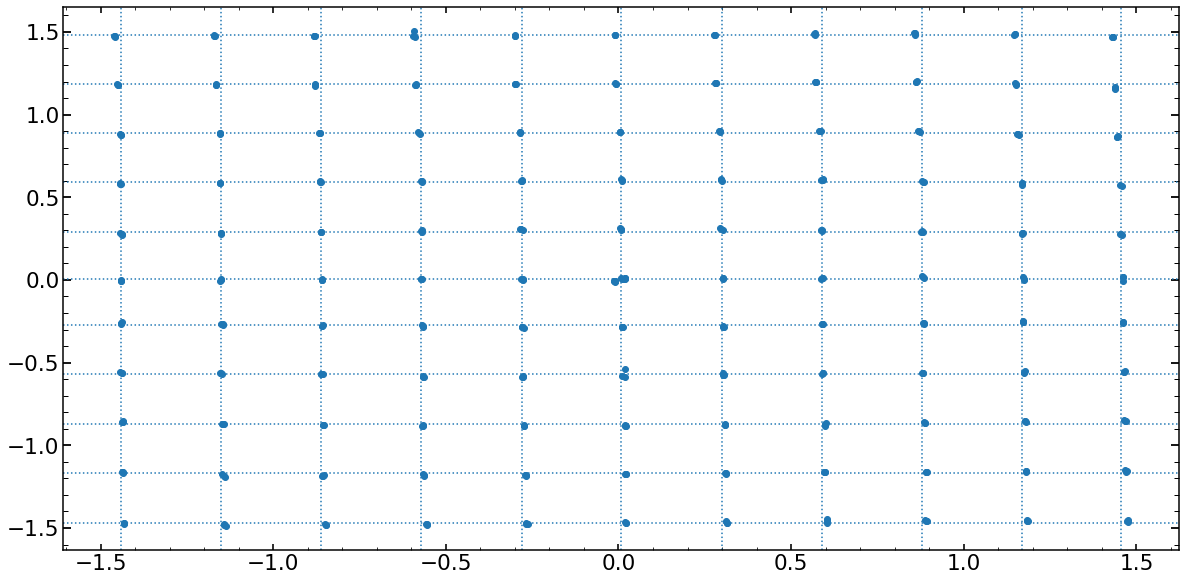

In [335]:
plt.figure(figsize=(20,10))
plt.scatter(array_of_centroid_differences[:,1],array_of_centroid_differences[:,2])
for i in range(len(y_mean_values)):
    plt.axhline(y_mean_values[i],ls=':')
    
for i in range(len(x_mean_values)):
    plt.axvline(x_mean_values[i],ls=':') 

In [336]:
dif_y=[]
for i in [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]:
    
    array_of_centroid_differences_i=array_of_centroid_differences[(array_of_x_y_z[:,1]<i+0.001) & (array_of_x_y_z[:,1]>(i-0.001))][:,2]
    
    dif_y.append([i,np.mean(array_of_centroid_differences_i),\
    0.74*(-np.quantile(array_of_centroid_differences_i,0.25)+\
                 np.quantile(array_of_centroid_differences_i,0.75))/np.sqrt(len(array_of_centroid_differences_i)-1)])
    
dif_x=[]
for i in [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]:
    
    array_of_centroid_differences_i=array_of_centroid_differences[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))][:,1]
    
    dif_x.append([i,np.mean(array_of_centroid_differences_i),\
    0.74*(-np.quantile(array_of_centroid_differences_i,0.25)+
                 np.quantile(array_of_centroid_differences_i,0.75))/np.sqrt(len(array_of_centroid_differences_i)-1)])
    
dif_x=np.array(dif_x)
difx_mean=dif_x[dif_x[:,0]==0][0][1]
dif_x[:,1]=dif_x[:,1]-dif_x[dif_x[:,0]==0][0][1]
#dif_x[:,2]=np.sqrt(dif_x[:,2]**2+dif_x[dif_x[:,0]==0][0][2])

dif_y=np.array(dif_y)
dify_mean=dif_y[dif_y[:,0]==0][0][1]
dif_y[:,1]=dif_y[:,1]-dif_y[dif_y[:,0]==0][0][1]
#dif_y[:,2]=np.sqrt(dif_y[:,2]**2+dif_y[dif_y[:,0]==0][0][2])

In [337]:
difx_mean=dif_x[dif_x[:,0]==0][0][1]
dify_mean=dif_y[dif_y[:,0]==0][0][1]

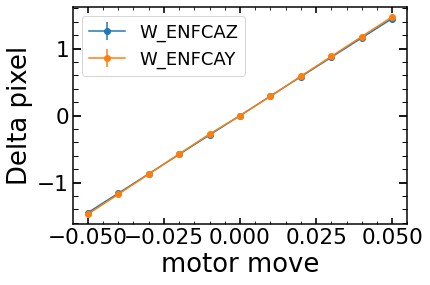

In [338]:
plt.errorbar(dif_x[:,0],dif_x[:,1],yerr=dif_x[:,2],marker='o',label='W_ENFCAZ')
plt.errorbar(dif_y[:,0],dif_y[:,1],yerr=dif_y[:,2],marker='o',label= 'W_ENFCAY')
plt.xlabel('motor move')
plt.ylabel('Delta pixel')
plt.legend()

In [339]:
y_mean_values=[]
for i in range(len(x_unique_positions)):
    y_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,1]==x_unique_positions[i]]][:,2]))
    
x_mean_values=[]
for i in range(len(y_unique_positions)):
    x_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,2]==y_unique_positions[i]]][:,1]))

In [340]:
p1_x=np.polyfit(dif_x[:,0],dif_x[:,1],deg=1,w=dif_x[:,2]**1)
p1_y=np.polyfit(dif_y[:,0],dif_y[:,1],deg=1,w=dif_y[:,2]**1)

p1_x_grid=polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_x))
p1_y_grid=polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_y))

print(p1_x)
print(p1_y)

p1_x_to_0=np.polyfit(dif_x[:,0],dif_x[:,1]-p1_x[1],deg=1,w=dif_x[:,2]**1)
p1_y_to_0=np.polyfit(dif_y[:,0],dif_y[:,1]-p1_y[1],deg=1,w=dif_y[:,2]**1)

print(p1_x_to_0)
print(p1_y_to_0)

p1_y=np.polyfit(dif_y[:,0][2:9],dif_y[:,1][2:9],deg=1,w=dif_y[:,2][2:9]**1)
p1_y

[28.98995435  0.00084844]
[29.35282965  0.00500261]
[28.98995435  0.        ]
[29.35282965 -0.        ]


array([29.11030035,  0.00617583])

In [341]:
dif_y[:,0][2:9]

array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03])

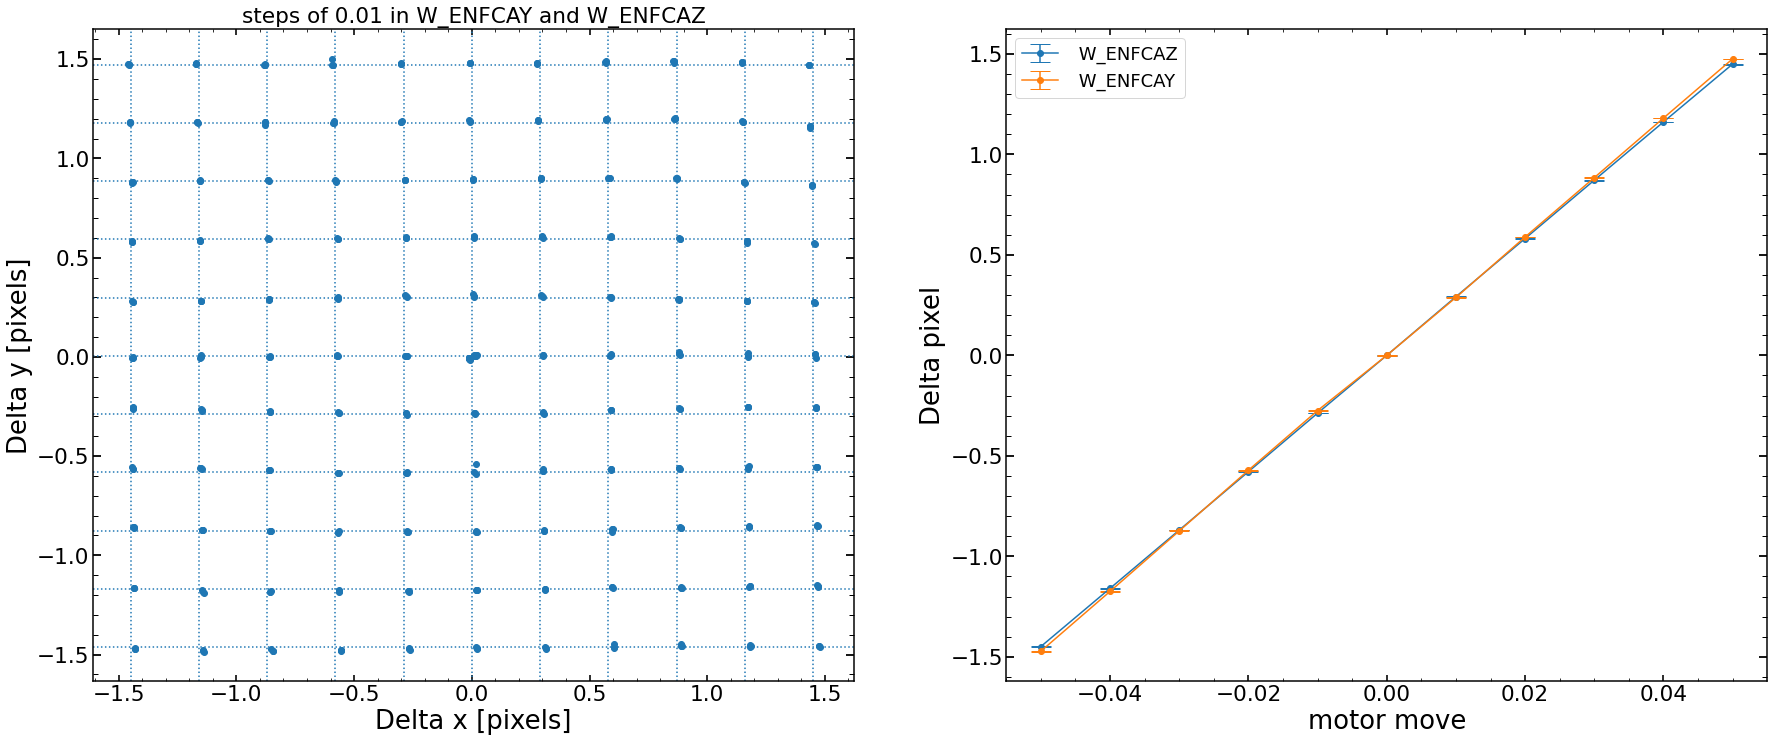

In [342]:
plt.figure(figsize=(30,12))

plt.subplot(121)
plt.title('steps of 0.01 in W_ENFCAY and W_ENFCAZ')
plt.scatter(array_of_centroid_differences[:,1]+dify_mean,array_of_centroid_differences[:,2]+difx_mean)

for i in range(len(y_mean_values)):
    plt.axhline(p1_y_grid[i],ls=':')
    
for i in range(len(x_mean_values)):
    plt.axvline(p1_x_grid[i],ls=':')    
    
    
plt.xlabel('Delta x [pixels]')
plt.ylabel('Delta y [pixels]')


plt.subplot(122)
plt.errorbar(dif_x[:,0],dif_x[:,1],yerr=dif_x[:,2],marker='o',label=' W_ENFCAZ',capsize=10)
plt.errorbar(dif_y[:,0],dif_y[:,1],yerr=dif_y[:,2],marker='o',label=' W_ENFCAY',capsize=10)
plt.xlabel('motor move')
plt.ylabel('Delta pixel')
plt.legend()


In [343]:
i=0.05
array_of_centroid_differences_i_y=array_of_centroid_differences[(array_of_x_y_z[:,1]<i+0.001) & (array_of_x_y_z[:,1]>(i-0.001))][:,2]
array_of_centroid_differences_i_x=array_of_centroid_differences[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))][:,1]

In [344]:
array_of_x_y_z[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))]

array([[ 0.    ,  0.05  ,  0.05  ],
       [ 0.    ,  0.05  ,  0.05  ],
       [ 0.    ,  0.05  ,  0.05  ],
       [-0.    ,  0.04  ,  0.05  ],
       [-0.    ,  0.04  ,  0.05  ],
       [-0.    ,  0.04  ,  0.05  ],
       [-0.    ,  0.03  ,  0.05  ],
       [-0.    ,  0.03  ,  0.05  ],
       [-0.    ,  0.03  ,  0.05  ],
       [-0.0001,  0.02  ,  0.05  ],
       [-0.0001,  0.02  ,  0.05  ],
       [-0.0001,  0.01  ,  0.05  ],
       [-0.0001,  0.01  ,  0.05  ],
       [-0.0001,  0.01  ,  0.05  ],
       [-0.0001, -0.    ,  0.05  ],
       [-0.0001, -0.    ,  0.05  ],
       [-0.0001, -0.    ,  0.05  ],
       [-0.0002, -0.01  ,  0.05  ],
       [-0.0002, -0.01  ,  0.05  ],
       [-0.0002, -0.01  ,  0.05  ],
       [-0.0002, -0.02  ,  0.05  ],
       [-0.0002, -0.02  ,  0.05  ],
       [-0.0002, -0.02  ,  0.05  ],
       [-0.0003, -0.03  ,  0.05  ],
       [-0.0003, -0.03  ,  0.05  ],
       [-0.0003, -0.03  ,  0.05  ],
       [-0.0004, -0.04  ,  0.05  ],
       [-0.0004, -0.04  ,  0

Text(0.5, 1.0, 'W_ENFCAZ=0.05')

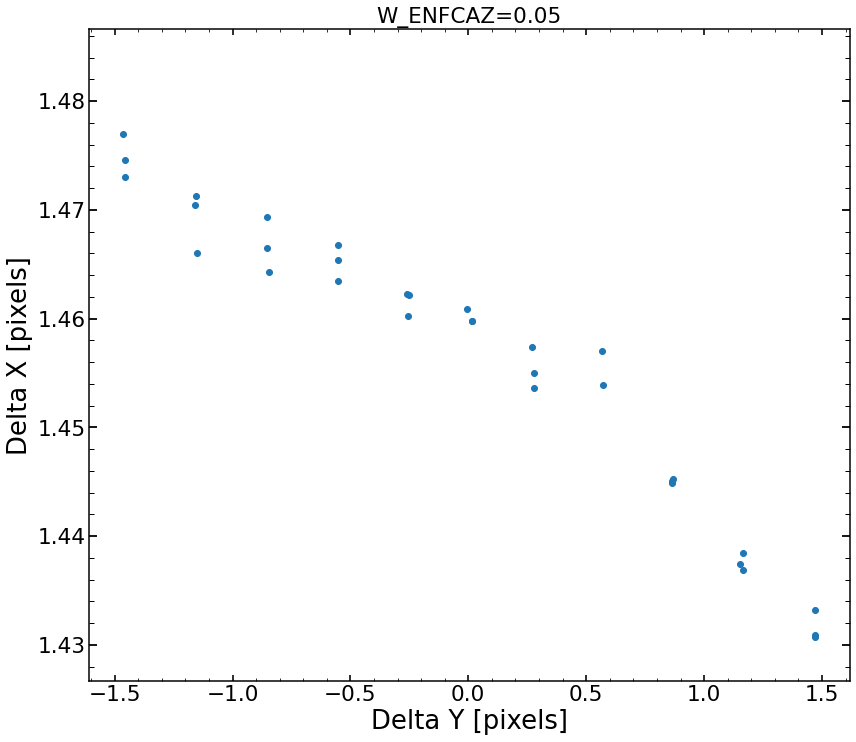

In [345]:
plt.figure(figsize=(30,12))
plt.subplot(121)
plt.plot(array_of_centroid_differences[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))][:,2],array_of_centroid_differences_i_x,marker='o',ls='')
plt.ylim(np.mean(array_of_centroid_differences_i_x)-0.03,np.mean(array_of_centroid_differences_i_x)+0.03)
plt.xlabel('Delta Y [pixels]')
plt.ylabel('Delta X [pixels]')
plt.title('W_ENFCAZ=0.05')


In [346]:
from numpy.polynomial.polynomial import polyval

In [355]:
np.sum((polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_x))-dif_x[:,1])**2/(dif_x[:,2])**2)/(len([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])-2)

0.37949775889465526

In [356]:
np.sum((polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_y))-dif_y[:,1])**2/(dif_y[:,2])**2)/(len([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])-2)

46.39423702239933

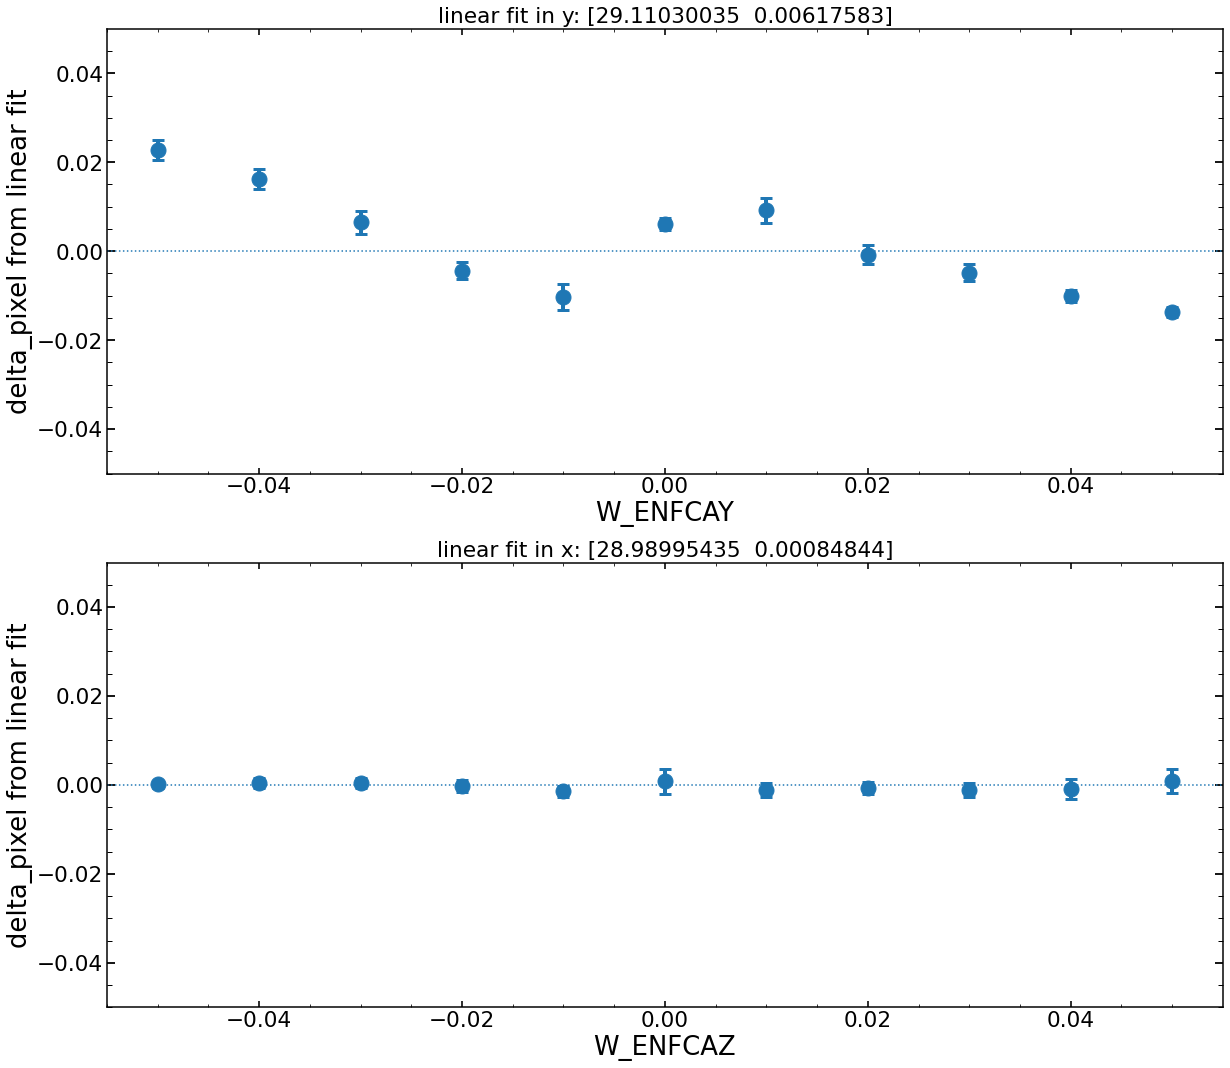

In [354]:
plt.figure(figsize=(20,18))

plt.subplot(211)
plt.errorbar([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],\
             polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_y))-dif_y[:,1],
            yerr=dif_y[:,2],capsize=6,capthick=3,fmt='o',elinewidth=4,ms=15)

plt.xlabel("W_ENFCAY")
plt.ylabel("delta_pixel from linear fit")
plt.title('linear fit in y: '+str(p1_y))
plt.ylim(-0.05,0.05)
plt.axhline(0,ls=':')

plt.subplot(212)

plt.errorbar([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],\
             polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_x))-dif_x[:,1],
            yerr=dif_x[:,2],capsize=6,capthick=3,fmt='o',elinewidth=4,ms=15)

plt.xlabel("W_ENFCAZ")
plt.ylabel("delta_pixel from linear fit")
plt.title('linear fit in x: '+str(p1_x))
plt.ylim(-0.05,0.05)
plt.axhline(0,ls=':')

# 7x7 wavefront 

In [ ]:
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  

In [162]:
finalHgAr_Feb2020_dataset

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,2,69,808,690.9346,0,HgAr,69,-19.25,0.0034,-40.7,0.006
1,2,69,875,696.7261,1,HgAr,69,0,0,0,0
2,2,70,992,706.8989,0,HgAr,70,16.93,0.268,28.33,0.088
3,2,71,1229,727.47876,1,HgAr,71,0,0,0,0
4,2,72,1358,738.6248,0,HgAr,72,-13.14,0.011,0,0
...,...,...,...,...,...,...,...,...,...,...,...
115,650,4002,2379,826.6699,0.5,HgAr,4071,18.83,0.0043,0,0
116,650,4003,2681,852.4029,0.5,HgAr,4072,-14.26,0.015,0,0
117,650,4008,3393,912.5693,1,HgAr,4077,0,0,0,0
118,650,4009,3515,922.7301,0,HgAr,4078,22.44,0.022,-13.14,0.011


In [156]:
with open('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-625 (frd)/Parameters_21.pkl', 'rb') as f:
    Parameters_21=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-625 (frd)/Parameters_24.pkl', 'rb') as f:
    Parameters_24=pickle.load(f)

In [157]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                          'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22', 
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_ilum_radius','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']    

In [158]:
for i in range(len(Parameters_21)):
    Parameters_21[i][-2]=1.8
    Parameters_21[i][-3]=0.37   
    Parameters_21[i][-6]=100000  
    Parameters_21[i][-5]=2.45
    Parameters_21[i][-4]=0.00266
    
    Parameters_24[i][-2]=1.8
    Parameters_24[i][-3]=0.37   
    Parameters_24[i][-6]=100000  
    Parameters_24[i][-5]=2.45
    Parameters_24[i][-4]=0.00266

In [159]:
model = LN_PFS_single(np.ones((20,20)),np.ones((20,20)),mask_image=np.ones((20,20)),dithering=1,save=1,zmax=22,verbosity=0,\
                     double_sources=None,double_sources_positions_ratios=[0,0],fit_for_flux=True,npix=1536,simulation_00=True)  

In [446]:
# 13 min
list_of_dif_residuals_24_21=[]
list_of_21=[]
list_of_24=[]

wavefront_values_HgAr=[]
list_of_wf_grid_HgAr=[]
list_of_wf_grid_HgAr_0=[]

for i in tqdm(range(120)):
    res_with_Image_21=model(Parameters_21[i],return_Image=True)[1]
    optPsf_cut_grating_convolved_21=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    list_of_wf_grid_HgAr.append(wf_grid)
    
    wavefront_values_HgAr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
    
    minchain_0=np.copy(Parameters_21[i])
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0,return_Image=True)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0.append(wf_grid)
 
 
    
    
    
    """
    res_with_Image_24=model(Parameters_24[i],return_Image=True)[1]
    optPsf_cut_grating_convolved_24=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')


    single_Psf_position=Psf_position(optPsf_cut_grating_convolved_21, int(round(9)),20 ,
                                     double_sources=False,double_sources_positions_ratios=[0,0],
                                                                           verbosity=1)    
    
    optPsf_cut_grating_convolved_21_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_21,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)
    optPsf_cut_grating_convolved_24_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_24,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)

    print(find_centroid_of_flux(optPsf_cut_grating_convolved_24_cut))
    print(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))


    shift_array=np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_24_cut))-np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))
    print(shift_array)

    optPsf_cut_grating_convolved_24_shifted=scipy.ndimage.interpolation.shift(optPsf_cut_grating_convolved_24,-np.flip(shift_array),mode='nearest')
    
    optPsf_cut_grating_convolved_21_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_21,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)
    optPsf_cut_grating_convolved_24_shifted_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_24_shifted,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)

    optPsf_cut_grating_convolved_21_cut.shape
    print(find_centroid_of_flux(optPsf_cut_grating_convolved_24_shifted_cut))
    print(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))


    shift_array_after_first_attempt=np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_24_shifted_cut))-np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))
    print(shift_array_after_first_attempt)
    
    optPsf_cut_grating_convolved_24_shifted_cut_20_20=resize(optPsf_cut_grating_convolved_24_shifted_cut,(20,20))
    optPsf_cut_grating_convolved_21_cut_20_20=resize(optPsf_cut_grating_convolved_21_cut,(20,20))

    optPsf_cut_grating_convolved_24_shifted_cut_20_20=optPsf_cut_grating_convolved_24_shifted_cut_20_20*50000/np.max(optPsf_cut_grating_convolved_24_shifted_cut_20_20)
    optPsf_cut_grating_convolved_21_cut_20_20=optPsf_cut_grating_convolved_21_cut_20_20*np.sum(optPsf_cut_grating_convolved_24_shifted_cut_20_20)/np.sum(optPsf_cut_grating_convolved_21_cut_20_20)
    list_of_21.append(optPsf_cut_grating_convolved_21_cut_20_20)
    list_of_24.append(optPsf_cut_grating_convolved_24_shifted_cut_20_20)
    list_of_dif_residuals_24_21.append(optPsf_cut_grating_convolved_21_cut_20_20-optPsf_cut_grating_convolved_24_shifted_cut_20_20)
    """
    
wavefront_values_HgAr=np.array(wavefront_values_HgAr)

  0%|                                                                                                                | 0/120 [00:00<?, ?it/s]/Users/nevencaplar/anaconda2/envs/idp2_pyfftw/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [06:42<00:00,  3.36s/it]


In [173]:
finalHgAr=finalHgAr_Feb2020_dataset

In [327]:
finalHgAr_7_7=[]
for i in range(len(finalHgAr)):

    if finalHgAr['fiber'][i] in [2,192,255,401,464,587,650]:
        if finalHgAr['wavelength'][i] in ['690.9346','738.6248','763.74286','795.0522','852.4029','912.5693','966.0642']:
            finalHgAr_7_7.append(i)
        
finalHgAr_7_7

[0,
 4,
 5,
 6,
 8,
 9,
 11,
 24,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 60,
 64,
 65,
 66,
 68,
 69,
 71,
 72,
 76,
 77,
 78,
 80,
 81,
 83,
 96,
 100,
 101,
 102,
 104,
 105,
 107,
 108,
 112,
 113,
 114,
 116,
 117,
 119]

In [332]:
finalHgAr.loc[2]

fiber                    2
xc                      70
yc                     992
wavelength        706.8989
close                    0
lamp                  HgAr
xc_effective            70
second_offset        16.93
second_ratio         0.268
second2_offset       28.33
second2_ratio        0.088
Name: 2, dtype: object

In [251]:
finalHgAr_sorted=finalHgAr.sort_values(by=['wavelength','fiber' ], ascending=[False,True])

In [361]:
len(finalHgAr_sorted)

120

In [341]:
finalHgAr_7_7

[0,
 4,
 5,
 6,
 8,
 9,
 11,
 24,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 60,
 64,
 65,
 66,
 68,
 69,
 71,
 72,
 76,
 77,
 78,
 80,
 81,
 83,
 96,
 100,
 101,
 102,
 104,
 105,
 107,
 108,
 112,
 113,
 114,
 116,
 117,
 119]

In [345]:
list_of_HgAr_sorted2

[11,
 59,
 71,
 83,
 107,
 119,
 22,
 57,
 105,
 117,
 8,
 32,
 44,
 68,
 80,
 7,
 19,
 31,
 55,
 67,
 91,
 5,
 53,
 65,
 77,
 101,
 113,
 16,
 28,
 76,
 88,
 100,
 3,
 15,
 39,
 74,
 1,
 13,
 25,
 49,
 61,
 85,
 97,
 24,
 36,
 48,
 72,
 84,
 108]

In [288]:
list_of_HgAr_sorted=[]
for i in range(len(finalHgAr_7_7)):
    list_of_HgAr_sorted.append(np.where(np.array((finalHgAr_sorted.index))==finalHgAr_7_7[i])[0][0])

In [362]:
list_of_HgAr_sorted2=[]
for i in range(len(finalHgAr_sorted)):
    if finalHgAr_sorted.index[i] in finalHgAr_7_7:
        print(i)
        list_of_HgAr_sorted2.append(finalHgAr_sorted.index[i])

0
2
3
5
6
8
9
20
22
23
25
26
28
29
30
32
33
35
36
38
39
50
52
53
55
56
58
59
60
62
63
65
66
68
69
70
72
73
75
76
78
79
110
112
113
115
116
118
119


In [365]:
list_of_HgAr_sorted2

[11,
 35,
 47,
 71,
 83,
 107,
 119,
 9,
 33,
 45,
 69,
 81,
 105,
 117,
 8,
 32,
 44,
 68,
 80,
 104,
 116,
 6,
 30,
 42,
 66,
 78,
 102,
 114,
 5,
 29,
 41,
 65,
 77,
 101,
 113,
 4,
 28,
 40,
 64,
 76,
 100,
 112,
 0,
 24,
 36,
 60,
 72,
 96,
 108]

In [354]:
if finalHgAr_sorted.index[0] in finalHgAr_7_7:
    print(True)

True


In [352]:
finalHgAr_7_7

[0,
 4,
 5,
 6,
 8,
 9,
 11,
 24,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 60,
 64,
 65,
 66,
 68,
 69,
 71,
 72,
 76,
 77,
 78,
 80,
 81,
 83,
 96,
 100,
 101,
 102,
 104,
 105,
 107,
 108,
 112,
 113,
 114,
 116,
 117,
 119]

In [242]:
# plot the results of the interpolation
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec17'


# take values for HgAr
x_HgAr=finalHgAr['xc_effective'].values[list_of_HgAr_sorted2]
y_HgAr=finalHgAr['yc'].values[list_of_HgAr_sorted2]
values_HgAr_RMS=wavefront_values_HgAr[:,5][list_of_HgAr_sorted2]
values_HgAr_max_min=wavefront_values_HgAr[:,1].astype(float)[list_of_HgAr_sorted2]-wavefront_values_HgAr[:,2].astype(float)[list_of_HgAr_sorted2]
values_HgAr_mean=wavefront_values_HgAr[:,4][list_of_HgAr_sorted2]

In [243]:
finalHgAr.loc[finalHgAr_7_7].shape

(49, 11)

In [244]:

# join these values
#x=np.concatenate((x_HgAr,x_Ne,x_Kr))
#y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
#colors_RMS= np.concatenate((values_HgAr_RMS,values_Ne_RMS,values_Kr_RMS))
#colors_max_min= np.concatenate((values_HgAr_max_min,values_Ne_max_min,values_Kr_max_min))
#colors_mean= np.concatenate((values_HgAr_mean,values_Ne_mean,values_Kr_mean))


x=x_HgAr
y=y_HgAr
colors_RMS= values_HgAr_RMS.astype(float)
colors_max_min= values_HgAr_max_min.astype(float)
colors_mean= values_HgAr_mean.astype(float)


min_colors_RMS=np.quantile(colors_RMS,0.1)
max_colors_RMS=np.quantile(colors_RMS,0.9)
min_colors_max_min=np.quantile(colors_max_min,0.1)
max_colors_max_min=np.quantile(colors_max_min,0.9)
min_colors_mean=np.quantile(colors_mean,0.1)
max_colors_mean=np.quantile(colors_mean,0.9)
abs_colors_mean=np.max([np.abs(min_colors_mean),np.abs(max_colors_mean)])

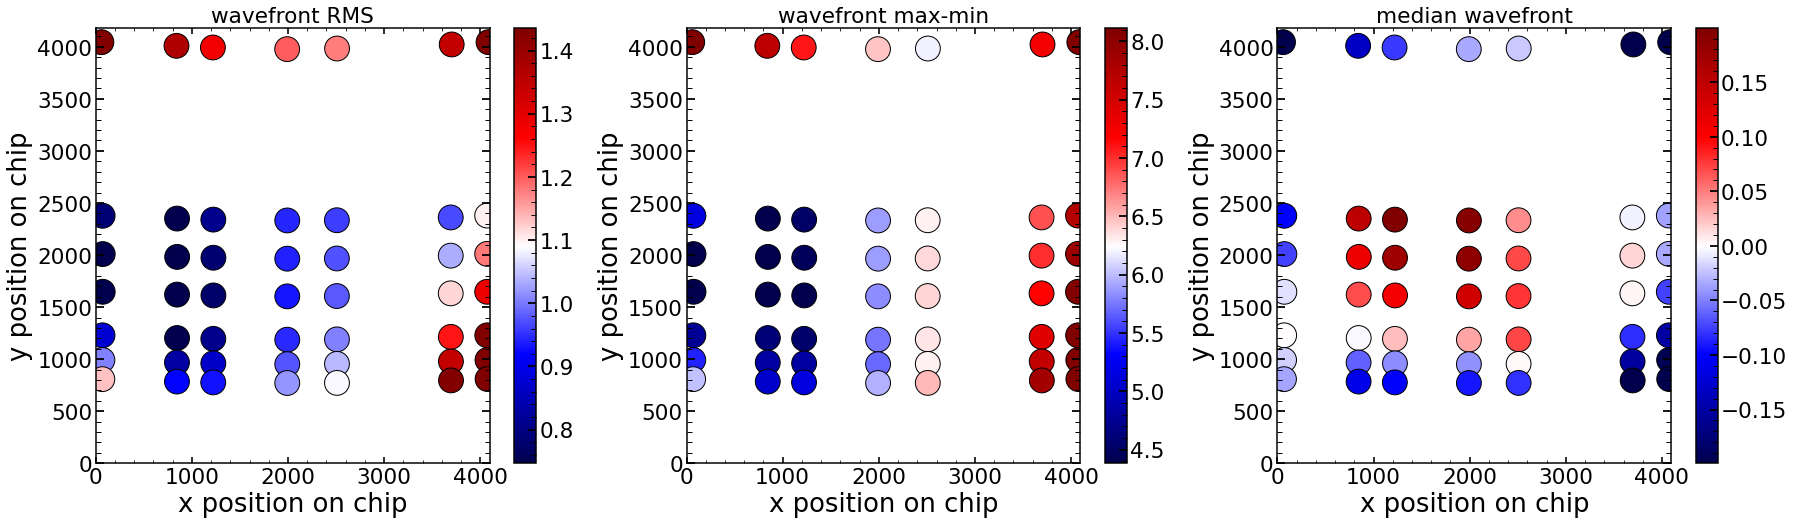

In [245]:
matplotlib.rcParams.update({'font.size': 18})


plt.figure(figsize=(30,8))

plt.subplot(131)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=colors_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='o')
#plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='s')
#plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront RMS')
plt.colorbar()


plt.subplot(132)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=colors_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='o')
#plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='s')
#plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront max-min')
plt.colorbar()

plt.subplot(133)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=colors_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='o')
#plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='s')
#plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('median wavefront')
plt.colorbar()

In [322]:
finalHgAr.iloc[11]

fiber                    2
xc                      59
yc                    4044
wavelength        966.0642
close                    1
lamp                  HgAr
xc_effective            59
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 11, dtype: object

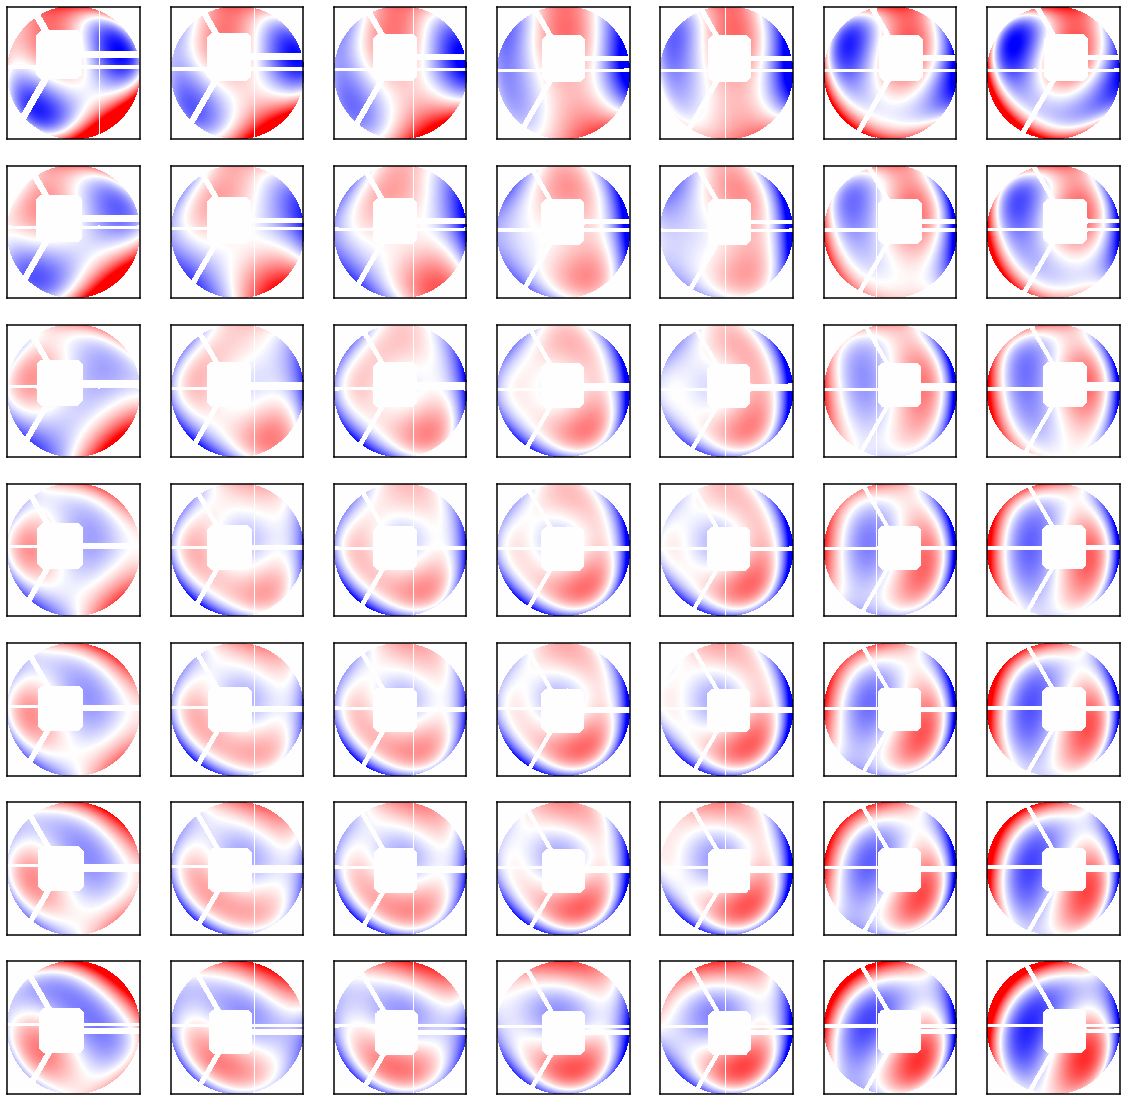

In [447]:
plt.figure(figsize=(20,20))
for x_i in range(7):
    for y_i in range(7):      
        plt.subplot(7,7,x_i*7+y_i+1)
        wavefront=list_of_wf_grid_HgAr[list_of_HgAr_sorted2[x_i*7+y_i]][768:2304,768:2304]
        plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')


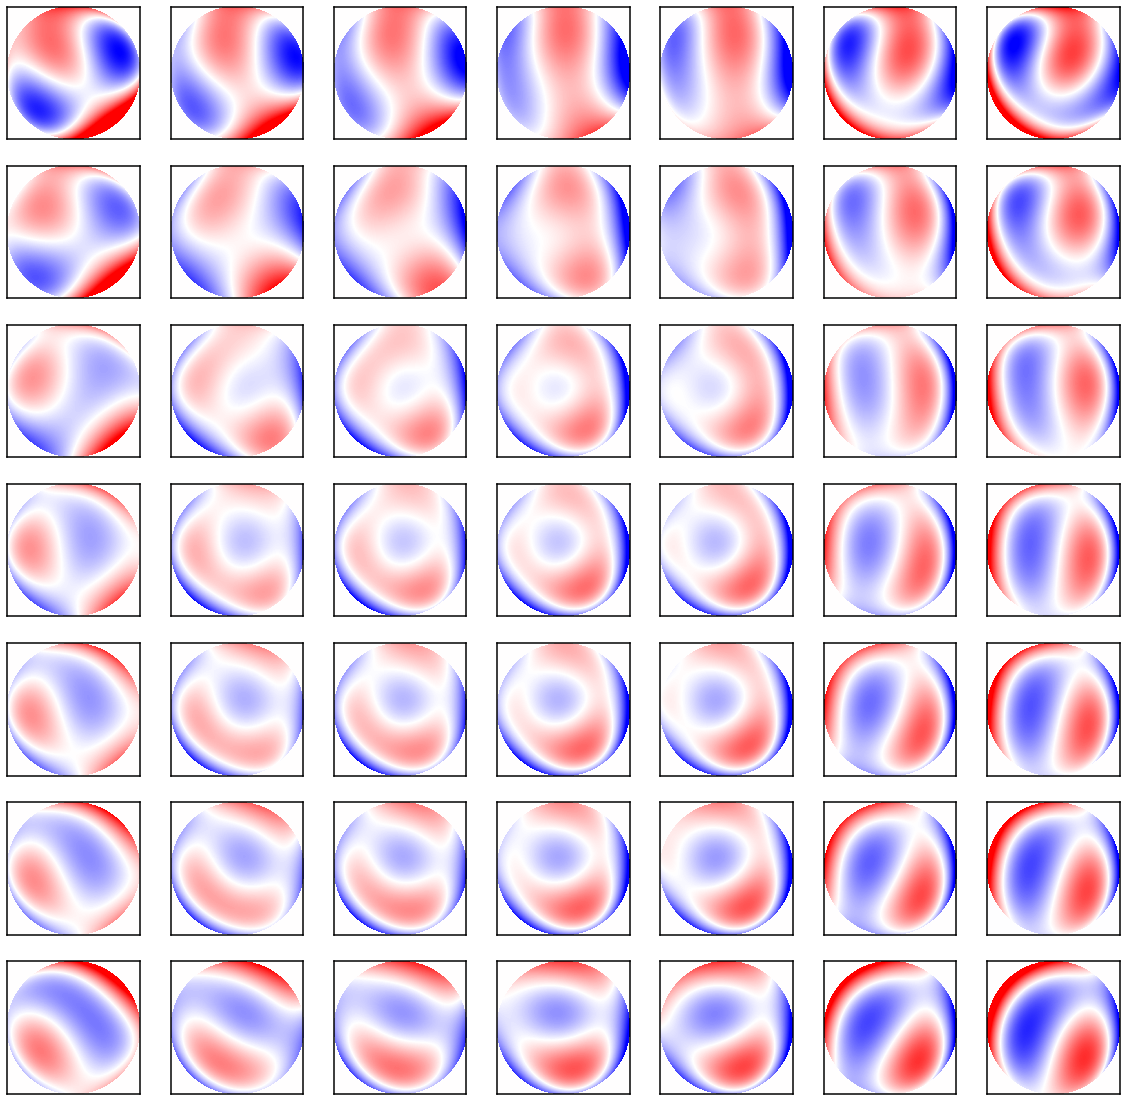

In [412]:
plt.figure(figsize=(20,20))
for x_i in range(7):
    for y_i in range(7):      
        plt.subplot(7,7,x_i*7+y_i+1)
        wavefront=list_of_wf_grid_HgAr_0[list_of_HgAr_sorted2[x_i*7+y_i]][768:2304,768:2304]
        plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')



In [212]:
int(1536-1536/2)

768

# Fake spot 

In [552]:
#date='Jul2020'
date='Sep1320'
obs=21400
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
obs_int=int(obs)
single_number='37'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

### fake dataset

In [596]:
finalHgAr_Feb2020_dataset.loc[120]=finalHgAr_Feb2020_dataset.loc[37].values

In [592]:
finalHgAr_Feb2020_dataset

,fiber,xc,yc,wavelength,close,lamp,xc_effective,second_offset,second_ratio,second2_offset,second2_ratio
0,2,69,808,690.9346,0,HgAr,69,-19.25,0.0034,-40.7,0.006
1,2,69,875,696.7261,1,HgAr,69,0,0,0,0
2,2,70,992,706.8989,0,HgAr,70,16.93,0.268,28.33,0.088
3,2,71,1229,727.47876,1,HgAr,71,0,0,0,0
4,2,72,1358,738.6248,0,HgAr,72,-13.14,0.011,0,0
...,...,...,...,...,...,...,...,...,...,...,...
116,650,4003,2681,852.4029,0.5,HgAr,4072,-14.26,0.015,0,0
117,650,4008,3393,912.5693,1,HgAr,4077,0,0,0,0
118,650,4009,3515,922.7301,0,HgAr,4078,22.44,0.022,-13.14,0.011
119,650,4016,4044,966.0642,1,HgAr,4085,0,0,0,0


In [597]:
finalHgAr_Feb2020_dataset.to_pickle("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/finalHgAr_Feb2020_dataset.pkl")

In [598]:
finalHgAr_Feb2020_dataset_test=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/finalHgAr_Feb2020_dataset.pkl",allow_pickle=True)

### fake sci_var_mask data

In [574]:
for i in range(9):
    if i==0:
        obs_name=21352
    if i==1:
        obs_name=21358
    if i==2:
        obs_name=21364
        
    if i==3:
        obs_name=21388
    if i==4:
        obs_name=21394
    if i==5:
        obs_name=21400
        
    if i==6:
        obs_name=21436
    if i==7:
        obs_name=21442
    if i==8:
        obs_name=21448
    
    sci_name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned_fake/sci'+str(obs_name)+'120HgAr_Stacked.npy '
    var_name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned_fake/var'+str(obs_name)+'120HgAr_Stacked.npy '
    mask_name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned_fake/mask'+str(obs_name)+'120HgAr_Stacked.npy '
    
    np.save(sci_name,list_of_single_model_image[i])
    np.save(var_name,list_of_var_images[i])
    np.save(mask_name,list_of_mask_images[i])

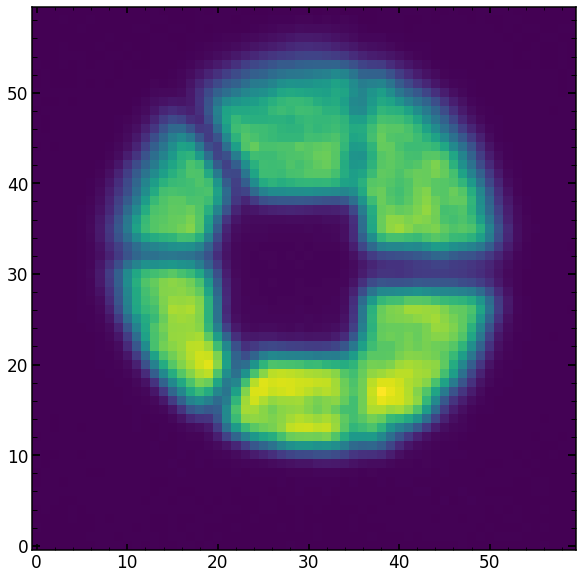

In [572]:
plt.imshow(np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci2135237HgAr_Stacked.npy'))

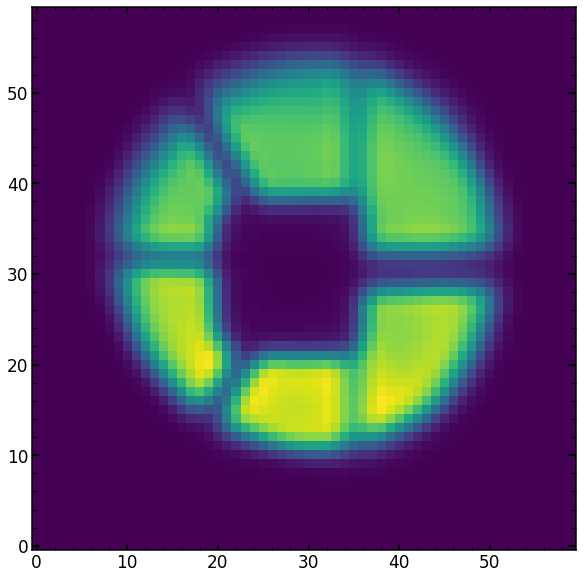

In [568]:
plt.imshow(list_of_single_model_image[0])

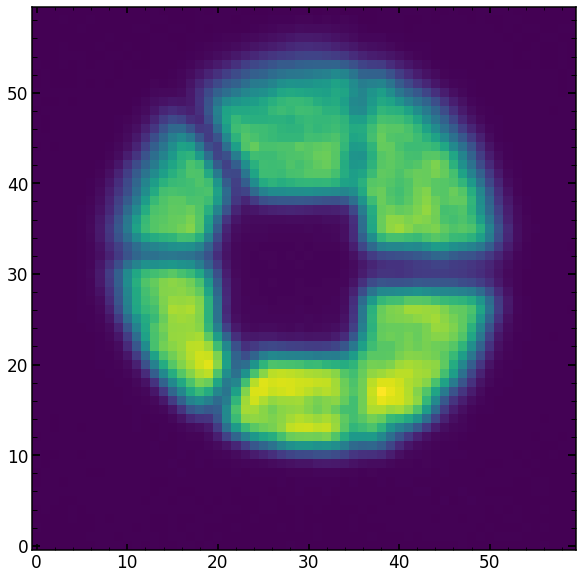

In [569]:
plt.imshow(list_of_sci_images[0])

### fake proposals

In [19]:
# proposal number 1 - fake proposal which is acctually the starrting point from zmax==2, Mar 06 data
twentytwo_or_extra=56
results_of_fit_input=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/results_of_fit_many_interpolation_HgAr_from_Mar06.pkl',allow_pickle=True)


list_of_allparameters=[]
list_of_defocuses=[]
for label in ['m4','m35','m3','m05','0','p05','p3','p35','p4']:
    try:
        list_of_allparameters.append(results_of_fit_input[label].loc[int(single_number)].values)
        list_of_defocuses.append(label)
    except:
        pass
    
array_of_allparameters=np.array(list_of_allparameters)

print('array_of_allparameters.shape: '+str(array_of_allparameters.shape))
print('twentytwo_or_extra: '+str(twentytwo_or_extra))
array_of_polyfit_1_parameterizations_proposal=model_multi.create_resonable_allparameters_parametrizations(array_of_allparameters=array_of_allparameters,\
                                                            list_of_defocuses_input=list_of_defocuses,zmax=twentytwo_or_extra,remove_last_n=2)

# lets be explicit that the shape of the array is 2d
array_of_polyfit_1_parameterizations_proposal_shape_2d=array_of_polyfit_1_parameterizations_proposal

array_of_allparameters.shape: (5, 44)
twentytwo_or_extra: 56


In [22]:
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_1',array_of_polyfit_1_parameterizations_proposal_shape_2d)

In [ ]:
# proposal number 2 - same as number 1 but one of parameters (z5) large offset 

In [26]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2=np.copy(array_of_polyfit_1_parameterizations_proposal_shape_2d)

In [27]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2[1][0]=-0.1
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2[1][1]=-0.8747

In [29]:
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2',array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2)

In [ ]:
# proposal number 3 - small offsets from Zernike 56 result that is ``correct result''

In [ ]:
array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_3

In [40]:
np.random.seed(420)
random_array=(np.random.rand(len(minchain_parametrization))/5+1)

array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_3=minchain_parametrization*(np.random.rand(len(minchain_parametrization))/5+1)

In [53]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3=\
model_multi.move_parametrizations_from_1d_to_2d(array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_3)

np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3',\
        array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3)

In [ ]:
# proposal number 4 -  one of parameters (z5) large offset 

In [50]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4=np.copy(array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3)

In [51]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4[1][0]=-0.1
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4[1][1]=-0.8747

In [52]:

np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4',\
        array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4)